# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В данном проекты я исследую данные с Яндекс.Недвижимость по продаже квартир, соединённые с данными геолокаций по квартирам. 

В процессе выполнения проекта я ознакомлюсь с данными, посмотрю на пропуски выбросы и по возможности их устраню. Потом изучу отдельные переменные и исследую, что определяет стоимость квартир, какие из населённых пунктов обладают самыми высокими ценами на квадратный метр и как зависит цена квартир в Санкт-Петербурге в зависимости от удалённости от центра.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import math

#### Загрузка данных

In [2]:
# Загрузим данные
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
# Посмотрим на результаты загрузки, покажем все колонки с переменными
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Сразу можно отметить, что в переменных ceiling_height, living_area, is_apartment, kitchen_area, balcony, parks_nearest, ponds_nearest и days_exposition есть пропуски (это то, что видно сразу из первых 5 строчек, может быть на самом деле пропусков больше). 

#### Общая информация о датафрейме

In [3]:
# Посмотрим детали данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

У нас в данных 22 переменных для каждой квартиры и всего 23699 квартир. Мы видим пропуски в ceiling_height (почти что 39% данных пропущено), в floors_total (пропущено очень мало значений, всего 0.4%), living_area (8%), is_apartment (88% данных пропущено!), kitchen_area (почти 10%), balcony (49%), locality_name (около 0.2% всего), airports_nearest (23%), cityCenters_nearest (тоже 23%), parks_around3000 (23%), parks_nearest (66%), ponds_around3000 (23%), ponds_nearest (6%) и days_exposition (13%)

В целом, видно, что есть много пропущенных данных, причём они разнятся от совсем небольшого процента, которыми можно принебречь, до больше половины всех данных и с этим придётся что-то делать.

Я изучила также названия переменных, и проблемной является только cityCenters_nearest, которую я заменю на city_centers_nearest

In [4]:
# Переименуем переменную
data = data.rename(columns={"cityCenters_nearest":"city_centers_nearest"})
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Общая гистограмма

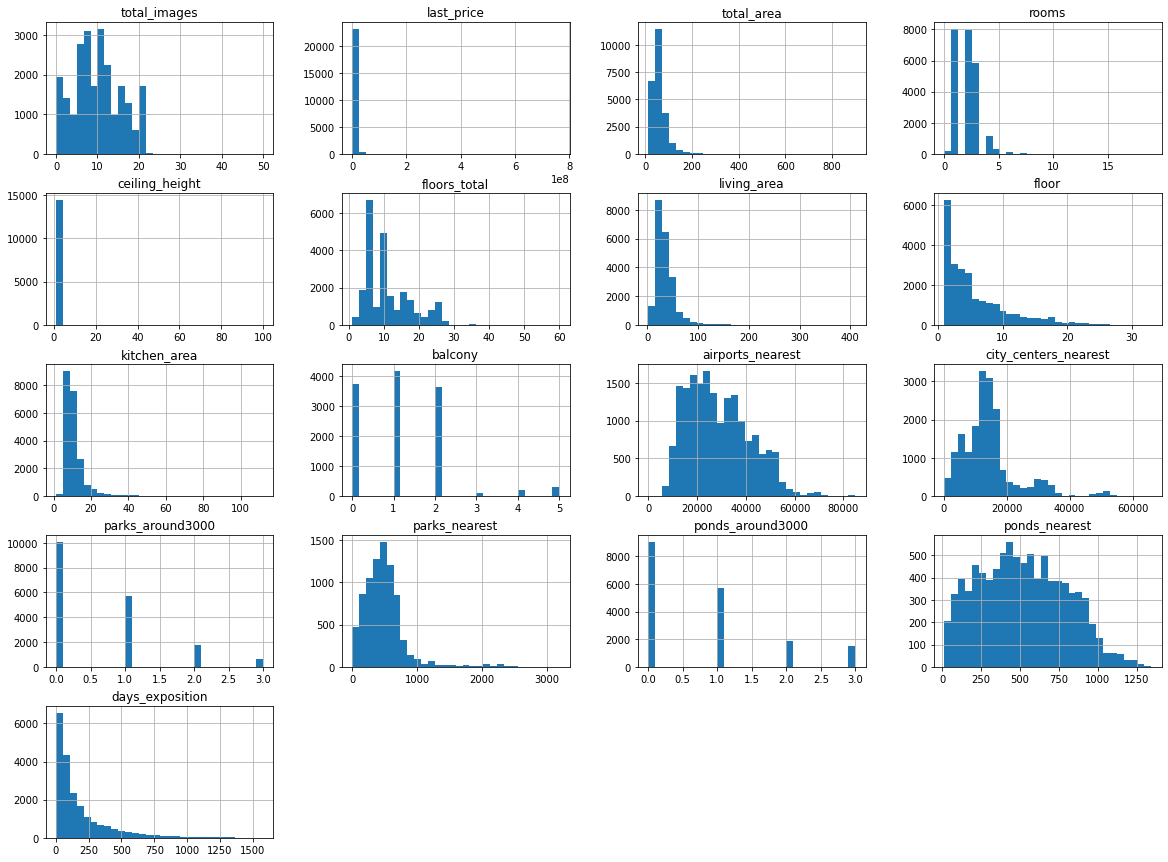

In [5]:
# Нарисуем гистограммы распределния наших переменных
data.hist(bins = 30, figsize = (20,15));

Посмотрим на гистограммы. 

Во-первых, тут гистограммы не всех переменных: все переменные object и bool не попали на гистограммы.
Посмотрим пока на имеющиеся гистограммы. Многие переменные распределены довольно адекватно и примерно как мы и ожидали бы. Но некоторые распределения кажутся странными, например, last_price и ceiling_heigt: их выборочные распределения как будто бы состоят из одного пика. Посмотрим их поподробнее.

In [6]:
# Посмотрю на детали last_price
data['last_price'].describe().apply('{0:.2f}'.format)

count        23699.00
mean       6541548.77
std       10887013.27
min          12190.00
25%        3400000.00
50%        4650000.00
75%        6800000.00
max      763000000.00
Name: last_price, dtype: object

Видно, что максимальное значение в 100 раз больше третьего квартиля, скорее всего это мешает читаемости гистограммы. Можно привести к log-scale

In [7]:
# приводим к логарифмической шкале
data['log_last_price']=np.log(data['last_price'])

Действительно, на log-scale распределение цены выглядит адекватно, похоже, что с данными всё в порядке.

Теперь посмотрию на переменную ceiling_height

In [8]:
# Смотрим описательную статистику.
data['ceiling_height'].describe().apply('{0:.2f}'.format)

count    14504.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: object

Тут тоже похожая ситуация - максимальное значение очевидно не соответствует реальности и от него надо будет избавиться. При этом минимальное значение тоже выглядит очень подозрительным. В идеале, на этапе предобработки можно осавить только данные, где потолок от 2 до 10 метров, но перед этим надо будет решить задачу с пропусками.
Пока что просто удалим наблюдения с потолком в 100 метров и с потолком в 1 м.

In [9]:
# Удаляем наблюдение с невероятно высоким и низким потолком.
data = data.loc[(data['ceiling_height']!=100) & (data['ceiling_height']!=1)].reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23697 entries, 0 to 23696
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23697 non-null  int64  
 1   last_price            23697 non-null  float64
 2   total_area            23697 non-null  float64
 3   first_day_exposition  23697 non-null  object 
 4   rooms                 23697 non-null  int64  
 5   ceiling_height        14502 non-null  float64
 6   floors_total          23611 non-null  float64
 7   living_area           21794 non-null  float64
 8   floor                 23697 non-null  int64  
 9   is_apartment          2774 non-null   object 
 10  studio                23697 non-null  bool   
 11  open_plan             23697 non-null  bool   
 12  kitchen_area          21419 non-null  float64
 13  balcony               12179 non-null  float64
 14  locality_name         23648 non-null  object 
 15  airports_nearest   

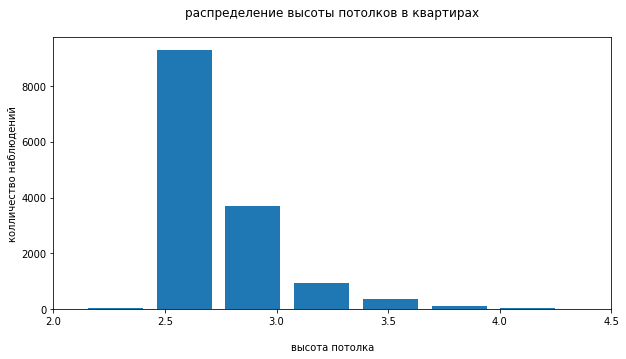

In [10]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['ceiling_height'], bins = 100, rwidth = 0.8);
plt.xlabel('\n' 'высота потолка')
plt.ylabel('колличество наблюдений')
plt.xlim(2,4.5)
plt.title('распределение высоты потолков в квартирах' '\n');


Выглядит довольно адекватно, хотя потолок в 2м всё равно кажется подозрительно низким, возможно на этапе дальнейшей обработки я его всё же удалю.

Теперь посмотрим на переменную с датой. Они сейчас записаны как строки и надо будет перевести их формат во временной. 

In [11]:
# Поменяю формат переменной на datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%M:%H:%S')

Теперь я посмотрю на переменную is_apartment. Её тип - object, хотя по характеру значений, она должна бы быть bool

In [12]:
# Считаем % пропусков
data['is_apartment'].isna().mean()

0.8829387686205005

Практически все значения NaN. Посмотрю на все возможные значения.

In [13]:
# Считаем наблюдения для каждых значений
data['is_apartment'].value_counts()

False    2725
True       49
Name: is_apartment, dtype: int64

Действительно тип должен быть бул, исходя из значений, но перед тем как менять тип переменных, надо понять, что делать с пропусками. Кажется, что пропущенные значения это False, потому что апартаменты вообще более редки, особенно на вторичном рынке.

In [14]:
# Заполняю пропуски
data['is_apartment'] = data['is_apartment'].fillna(False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23697 entries, 0 to 23696
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23697 non-null  int64         
 1   last_price            23697 non-null  float64       
 2   total_area            23697 non-null  float64       
 3   first_day_exposition  23697 non-null  datetime64[ns]
 4   rooms                 23697 non-null  int64         
 5   ceiling_height        14502 non-null  float64       
 6   floors_total          23611 non-null  float64       
 7   living_area           21794 non-null  float64       
 8   floor                 23697 non-null  int64         
 9   is_apartment          23697 non-null  bool          
 10  studio                23697 non-null  bool          
 11  open_plan             23697 non-null  bool          
 12  kitchen_area          21419 non-null  float64       
 13  balcony         

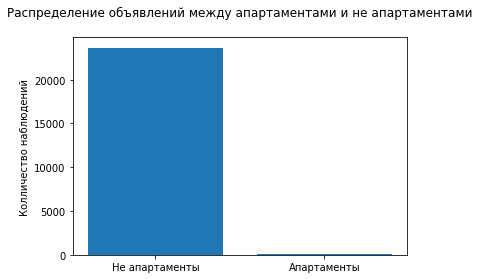

In [15]:
# строю столбчатую диаграмму
fig, ax = plt.subplots()

ax.bar(data['is_apartment'].value_counts().index, data['is_apartment'].value_counts());
plt.xticks([False,True], ['Не апартаменты', 'Апартаменты']);
plt.ylabel('Колличество наблюдений');
plt.title('Распределение объявлений между апартаментами и не апартаментами' '\n');

Теперь почти всё объявления не о продаже апартаментов.

Теперь посмотрим на locality_name.

In [16]:
# Посмотрим, какие есть варианты в locality_name
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Вариантов действительно очень много и мы с этим будем работать дальше. На данном этапе хотелось бы просто понять распределение объявлений между Санкт-Петербургом и областью.

In [17]:
# Создадим функцию
def city(locality):
    if locality == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    else:
        return 'Область'
    
# Создаю новую переменну.
data['locality_type'] = data['locality_name'].apply(city)

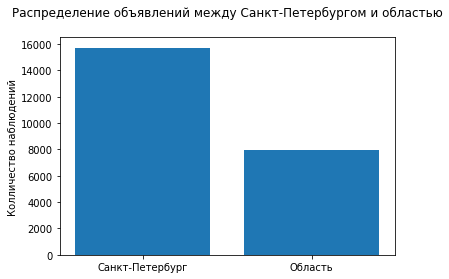

In [18]:
# строю столбчатую диаграмму
fig, ax = plt.subplots()

ax.bar(data['locality_type'].value_counts().index, data['locality_type'].value_counts());
plt.ylabel('Колличество наблюдений');
plt.title('Распределение объявлений между Санкт-Петербургом и областью' '\n');

Объявлений в Санкт-Перербурге почти что в два раза больше, чем в области

Осталось посмотреть на распределение студий и квартир с открытой планировкой.

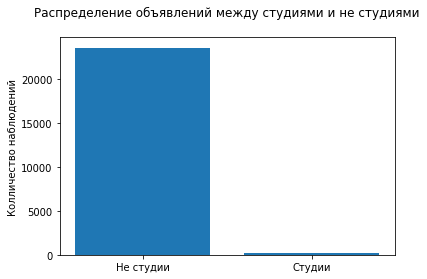

In [19]:
# строю столбчатую диаграмму
fig, ax = plt.subplots()

ax.bar(data['studio'].value_counts().index, data['studio'].value_counts());
plt.xticks([False,True], ['Не студии', 'Студии']);
plt.ylabel('Колличество наблюдений');
plt.title('Распределение объявлений между студиями и не студиями' '\n');

Студий очень мало по сравнению с другими квартирами. Это тоже кажется правильным, распределение на вызывает сомнений в качестве этих данных.

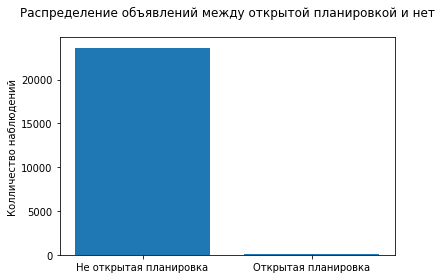

In [20]:
# строю столбчатую диаграмму
fig, ax = plt.subplots()

ax.bar(data['open_plan'].value_counts().index, data['open_plan'].value_counts());
plt.xticks([False,True], ['Не открытая планировка', 'Открытая планировка']);
plt.ylabel('Колличество наблюдений');
plt.title('Распределение объявлений между открытой планировкой и нет' '\n');

То же самое наблюдаем в объявлениях про открытую планировку: их очень мало.

В данном разделе я ознакомилась с данными, поменяла название переменной, провела первичну обработку данных, необходимую для общего знакомства с распределениями переменных. 

### Предобработка данных

#### Обрабока пропусков

Посмотрим на процент пропуска в разных переменных.

In [21]:
# Выводим процент пропусков
pd.DataFrame(data.isna().mean()*100).rename(columns = {0:"percent"}).style.background_gradient('coolwarm')

,percent
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.802380
floors_total,0.362915
living_area,8.030552
floor,0.000000
is_apartment,0.000000


Есть некоторые переменные, где пропусков очень мало, например locality_name и floors_total. Скорее всего, их не указали в объявлении. Таких данных очень мало и их можно просто оставить, это не должно повлиять на результат.

In [22]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

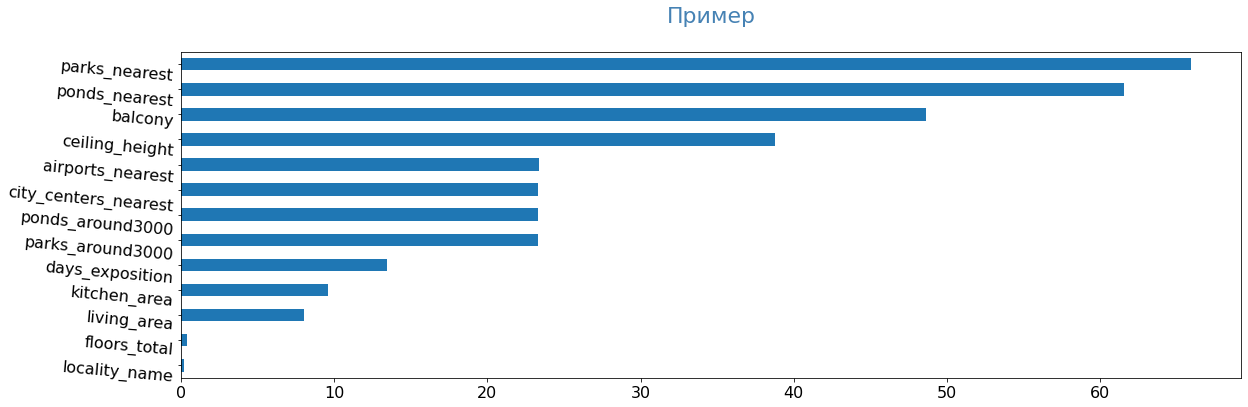

In [23]:
pass_value_barh(data)

Пропуски в значении балконов наиболее вероятно означают, что его там нет. Скорее всего, владельцы просто не указывали колличество балконов в таких объявлениях.

In [24]:
# Заполняем пропуски значением
data['balcony'] = data['balcony'].fillna(0)
data.isna().mean().apply('{0:.2f}'.format)

total_images            0.00
last_price              0.00
total_area              0.00
first_day_exposition    0.00
rooms                   0.00
ceiling_height          0.39
floors_total            0.00
living_area             0.08
floor                   0.00
is_apartment            0.00
studio                  0.00
open_plan               0.00
kitchen_area            0.10
balcony                 0.00
locality_name           0.00
airports_nearest        0.23
city_centers_nearest    0.23
parks_around3000        0.23
parks_nearest           0.66
ponds_around3000        0.23
ponds_nearest           0.62
days_exposition         0.13
log_last_price          0.00
locality_type           0.00
dtype: object

In [25]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
log_last_price              0
locality_type               0
dtype: int64

Процент пропуска в living_area и total_area повыше, но всё равно небольшой. Можно было бы их тоже просто удалить, но поскольку у нас нет пропусков, можно восстановить жилую площадь и прощадь кухни из общей площади. 

Посмотрим, насколько вообще данные для площадей адекватны, нет ли у нас таких налюдений, где жилая площадь и кухня больше общей.

In [26]:
# вывожу срез
print(data.query('total_area<kitchen_area+living_area')['total_area'].count())
print(data.query('0.9*total_area<kitchen_area+living_area')['total_area'].count())

64
461


Оказывается в 64 квартирах не сходятся площади, такие наблюдения надо будет удалить. А ещё в 397 остаётся очень мало места на нежилую площадь, но оставим пока такие наблюдения.

#### check nan

In [27]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23697 entries, 0 to 23696
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23697 non-null  int64         
 1   last_price            23697 non-null  float64       
 2   total_area            23697 non-null  float64       
 3   first_day_exposition  23697 non-null  datetime64[ns]
 4   rooms                 23697 non-null  int64         
 5   ceiling_height        14502 non-null  float64       
 6   floors_total          23611 non-null  float64       
 7   living_area           21794 non-null  float64       
 8   floor                 23697 non-null  int64         
 9   is_apartment          23697 non-null  bool          
 10  studio                23697 non-null  bool          
 11  open_plan             23697 non-null  bool          
 12  kitchen_area          21419 non-null  float64       
 13  balcony         

In [28]:
# удаляю наблюдения
data=data.query('total_area>=kitchen_area+living_area').reset_index(drop=True)

In [29]:
# check
data.shape[0]

20916

In [30]:
# Я посчитала, какой в среднем процент от жилой площади составляет кухня и жилая площадь и домножила этот коэффициент на общий метраж соответствующих квартир.
data['kitchen_area'] = data['kitchen_area'].fillna(((data['kitchen_area']/data['total_area']).mean())*data['total_area'])
data['living_area'] = data['living_area'].fillna(((data['living_area']/data['total_area']).mean())*data['total_area'])

Проверю, что в результате этой замены у меня не добавились новые странные наблюдения с очень маленькой нежилой площадью 

In [31]:
# делаю срез
data.query('0.9*total_area<kitchen_area+living_area')['total_area'].count()

397

Новых подозрительных наблюдений не добавилось, все 397 были ещё до замены пропущенных значений, а значит алгоритм замены не добавил аномалий в данные. 

#### Обработка дубликатов

Перед дальнейшей работой с пропусками, посмотрю, есть ли в данных явные дубликаты

In [32]:
# процент явных дубликатов
data.duplicated().mean()

0.0

Явных дубликатов по значениям всех переменных нет, но нужно ещё посмотреть, что нет явных дубликатов по подмножеству значений.

In [33]:
# процент явных дубликатов по подмножеству
(data.duplicated(subset = ['total_area', 'living_area', 'kitchen_area', 'floor', 'floors_total', 
                           'rooms', 'city_centers_nearest', 'locality_name']).mean())

0.0015777395295467585

Оказывается, что по подмножеству значений есть дубликаты, хоть и немного. Удалим их.

In [34]:
# удаляю явные дубликаты в подмножестве переменных
data=(data.drop_duplicates(subset =['total_area', 'living_area', 'kitchen_area', 'floor', 'floors_total', 
                                    'rooms', 'city_centers_nearest', 'locality_name']).reset_index(drop = True))

Есть много пропусков в данных местности. Их будет логичнее заменить медианами по категрии для местности, но для этого сначала надо разобраться с переменной для названия местности и привести её к хорошему виду. Посмотрим ещё раз на значения в locality_name.

In [35]:
# считаем число разных названий
len(data['locality_name'].unique())

346

На данный момент у нас есть 346 уникальных значений в locality_name, но среди них есть неявные дубликаты. Удалим их.

In [36]:
# переименуем потенциальные дубликаты в названии
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')

In [37]:
# считаем число разных названий
len(data['locality_name'].unique())

304

In [38]:
# check
data.locality_name.nunique()

303

Разница в 1 между nunique и unique из-за того, что nunique отбрасывает пропущенные значения, а unique считает.

Я избавилась от 42 неявных дубликатов. Посмотрим, не возникло ли после этого новых явных дубликатов.

In [39]:
# вывожу число явных дубликатов
print(data.duplicated().mean())
(print(data.duplicated(subset = ['total_area', 'living_area', 'kitchen_area', 'floor', 
                                 'floors_total', 'rooms', 'city_centers_nearest', 'locality_name']).mean()))

0.0
4.7885840157065554e-05


Похоже, что есть ещё один явный дубликат по подмножеству дунных, посмотрим на него

In [40]:
# вывожу наблюдения - дубликаты
(data.loc[data[['total_area', 'living_area', 'kitchen_area', 'floor', 'floors_total', 'rooms',
                'city_centers_nearest', 'locality_name']].duplicated()])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,log_last_price,locality_type
8912,6,2000000.0,46.0,2017-09-25,2,NaN,5.0,30.0,1,False,False,False,6.0,0.0,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,10.0,14.508658,Область


Действительно, появился ещё один явный дубликат по подмножеству переменных, удалим его.

In [41]:
# удаляю наблюдение
data = (data.drop_duplicates(subset = ['total_area', 'living_area', 'kitchen_area', 'floor', 'floors_total', 
                                       'rooms', 'city_centers_nearest', 'locality_name']).reset_index(drop = True))

#### Обработка пропусков

Посмотрим, как распределены пропуски по населённым пунктам.

In [42]:
# считаю процент пропусков по населённым пунктам
data['city_centers_nearest'].isna().groupby(data['locality_name']).mean()

locality_name
Бокситогорск            1.0
Волосово                1.0
Волхов                  1.0
Всеволожск              1.0
Выборг                  1.0
                       ... 
село Путилово           1.0
село Рождествено        1.0
село Русско-Высоцкое    1.0
село Старая Ладога      1.0
село Шум                1.0
Name: city_centers_nearest, Length: 303, dtype: float64

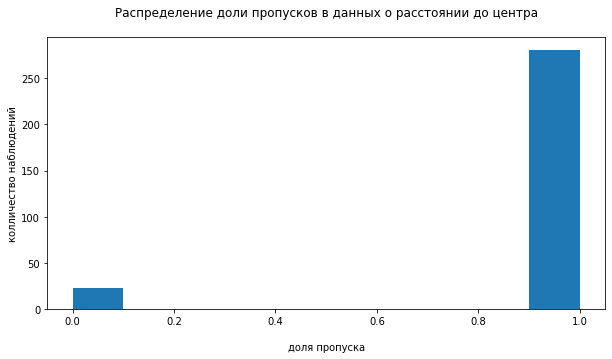

In [43]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['city_centers_nearest'].isna().groupby(data['locality_name']).mean(), rwidth = 1)
plt.grid(visible = False)
plt.xlabel('\n' 'доля пропуска')
plt.ylabel('колличество наблюдений')
plt.title('Распределение доли пропусков в данных о расстоянии до центра' '\n');

Получается, что в данных есть два типа локаций - где данные в city_centers_nearest полностью пропущены, и где их пропущено очень мало (на такой гистограмме даже кажется, что вообще не пропущены). Посмотрим, для каких локаций у нас пропущены не все данные в city_centers_nearest.

In [44]:
# процент пропуска в населённых пунктах с пропусками < 100%
(data['city_centers_nearest'].isna().groupby(data['locality_name']).mean().loc[data['city_centers_nearest']
                                                                               .isna()
                                                                               .groupby(data['locality_name'])
                                                                               .mean()<1])

locality_name
Зеленогорск                0.000000
Колпино                    0.003115
Красное Село               0.012270
Кронштадт                  0.011236
Ломоносов                  0.008065
Павловск                   0.000000
Петергоф                   0.000000
Пушкин                     0.002967
Санкт-Петербург            0.003069
Сестрорецк                 0.000000
поселок Александровская    0.000000
поселок Белоостров         0.000000
поселок Лисий Нос          0.000000
поселок Металлострой       0.000000
поселок Молодёжное         0.000000
поселок Парголово          0.000000
поселок Песочный           0.000000
поселок Понтонный          0.000000
поселок Репино             0.000000
поселок Сапёрный           0.000000
поселок Стрельна           0.000000
поселок Усть-Ижора         0.000000
поселок Шушары             0.005102
Name: city_centers_nearest, dtype: float64

Видно, что на самом деле не во всех населённых пунктах с малым числом пропусков их вообще нет. В некоторых их просто очень мало. В частности, что нам будет важно для дальнейшего анализа - это что в Санкт-Петербурге есть пропуски (хоть и всего 0.3%). Поскольку в следующей части проекта я исследую среднюю цену квадратного метра в Санкт-Перербурге для каждого километра, я не буду заменять данные пропуски на медиану, потому что это может исказить результат анализа. Остальные же пропуски в данных населённых пунктах можно заменить на медианное значение для группы, это не должно сильно повлиять.

Теперь я хочу заменить пропуски в географических данных на медианное значение для населённого пункта для всех населённых пунктов кроме Санкт-Петербурга.

In [45]:
# запоним пропуски для всех населённых пунктов кроме СПб
for var in (['airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 
             'ponds_around3000', 'ponds_nearest']):
    for l in (data.query('locality_name!="Санкт-Петербург"')[var].isna()
              .groupby(data['locality_name']).mean().loc[(data[var].isna()
                                                          .groupby(data['locality_name'])
                                                          .mean()<1) & (data[var].isna()
                                                                        .groupby(data['locality_name'])
                                                                        .mean()>0)].index):
        data.loc[(data['locality_name']==l) & (data[var].isna()), var]  = (data.loc[(data['locality_name']==l), var]
         .median())

Проверяем результат.

In [46]:
data.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.364477
floors_total            0.001868
living_area             0.000000
floor                   0.000000
is_apartment            0.000000
studio                  0.000000
open_plan               0.000000
kitchen_area            0.000000
balcony                 0.000000
locality_name           0.001820
airports_nearest        0.221818
city_centers_nearest    0.220764
parks_around3000        0.220764
parks_nearest           0.603055
ponds_around3000        0.220764
ponds_nearest           0.557562
days_exposition         0.137726
log_last_price          0.000000
locality_type           0.000000
dtype: float64

У нас всё равно остались пропуски в географических переменных, но их стало меньше. Теперь я обработаю пропуски в ceiling_height и days_exposition.

#### check kernel

Для переменных ceiling_height и floors_total я применю метод KNN для заполнения пропущенных значений. Пропуски в days_exposition я заполнять не буду, потому что эти пропуски важны и говорят, что квартира пока не была продана.

In [47]:
# применяем knn алгоритм
d = (data.drop(columns = ['locality_name', 'first_day_exposition', 'log_last_price', 'locality_type', 'days_exposition'])
     .values)
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
imputer.fit(d)
dtrans = imputer.transform(d)

In [48]:
# Запишем обновлённые переменные
for var in ['ceiling_height', 'floors_total']:
    data[var] = (pd.DataFrame(dtrans, columns = data
                              .drop(columns = 
                                    ['locality_name', 'first_day_exposition', 'log_last_price', 
                                     'locality_type', 'days_exposition']).columns)[var])

Посмотрим на данные после замены пропусков.

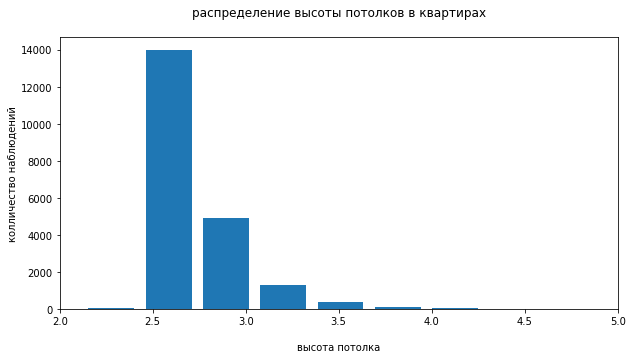

In [49]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['ceiling_height'], bins = 100, rwidth = 0.8);
plt.xlabel('\n' 'высота потолка')
plt.ylabel('колличество наблюдений')
plt.xlim(2,5)
plt.title('распределение высоты потолков в квартирах' '\n');


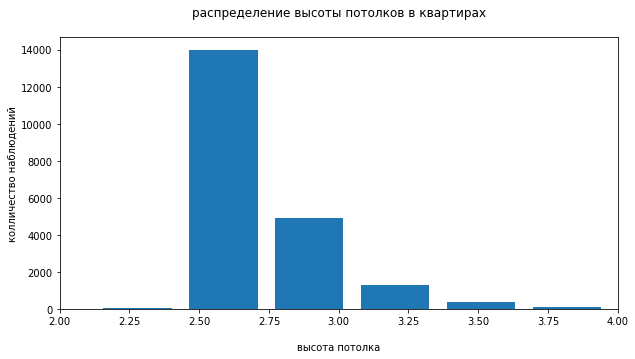

In [50]:
plt.figure(figsize = (10,5))
plt.hist(data['ceiling_height'], bins = 100, rwidth = 0.8);
plt.xlabel('\n' 'высота потолка')
plt.ylabel('колличество наблюдений')
plt.xlim(2,4)
plt.title('распределение высоты потолков в квартирах' '\n');


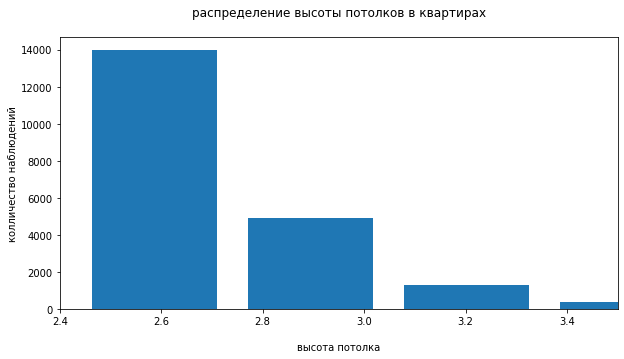

In [51]:
plt.figure(figsize = (10,5))
plt.hist(data['ceiling_height'], bins = 100, rwidth = 0.8);
plt.xlabel('\n' 'высота потолка')
plt.ylabel('колличество наблюдений')
plt.xlim(2.4,3.5)
plt.title('распределение высоты потолков в квартирах' '\n');


Распределение высоты потолка выглядит адекватно.

#### Изменение типов переменных

In [52]:
# смотрим на типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20882 entries, 0 to 20881
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20882 non-null  int64         
 1   last_price            20882 non-null  float64       
 2   total_area            20882 non-null  float64       
 3   first_day_exposition  20882 non-null  datetime64[ns]
 4   rooms                 20882 non-null  int64         
 5   ceiling_height        20882 non-null  float64       
 6   floors_total          20882 non-null  float64       
 7   living_area           20882 non-null  float64       
 8   floor                 20882 non-null  int64         
 9   is_apartment          20882 non-null  bool          
 10  studio                20882 non-null  bool          
 11  open_plan             20882 non-null  bool          
 12  kitchen_area          20882 non-null  float64       
 13  balcony         

Изучу типы переменных. last_price имеет тип float, но скорее всего цена до копеек не насколько важна в стоимости квартиры, поэтому заменю ее на int, floors_total переведу в int, balcony переведу в int.

Проверю переменные living_area, kitchen_area, total_area, возможно, нам тоже не нужно их сохранять дробными.

In [53]:
# выводим часть таблицы
data[['total_area','living_area', 'kitchen_area']]

,total_area,living_area,kitchen_area
0,108.00,51.0,25.00
1,40.40,18.6,11.00
2,56.00,34.3,8.30
3,100.00,32.0,41.00
4,30.40,14.4,9.10
...,...,...,...
20877,30.00,17.5,6.00
20878,62.40,40.0,8.00
20879,133.81,73.3,13.83
20880,59.00,38.0,8.50


После рассмотрения всё же кажется, что их лучше оставить дробными.

In [54]:
# меняю тип переменных
for var in ['last_price', 'floors_total','balcony']:
    data[var] = round(data[var]).apply(int)


In [55]:
# меняем тип переменных
# for var in ['last_price', 'floors_total','balcony', 'airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']:
#     data[var]=round(data[var])
#     data[var] = data[var].astype('Int64')
    

In [56]:
# выводим информацию о типах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20882 entries, 0 to 20881
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20882 non-null  int64         
 1   last_price            20882 non-null  int64         
 2   total_area            20882 non-null  float64       
 3   first_day_exposition  20882 non-null  datetime64[ns]
 4   rooms                 20882 non-null  int64         
 5   ceiling_height        20882 non-null  float64       
 6   floors_total          20882 non-null  int64         
 7   living_area           20882 non-null  float64       
 8   floor                 20882 non-null  int64         
 9   is_apartment          20882 non-null  bool          
 10  studio                20882 non-null  bool          
 11  open_plan             20882 non-null  bool          
 12  kitchen_area          20882 non-null  float64       
 13  balcony         

#### Обработка эстремальных значений

Посмотрим на странные и выбивающиесяя значения в переменных. Для начала посмотрим на описательную статистику переменных.

In [57]:
# Вывожу описательную статистику
data.describe().style.format("{:,.1f}")

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,log_last_price
count,"20,882.0","20,882.0","20,882.0","20,882.0","20,882.0","20,882.0","20,882.0","20,882.0","20,882.0","20,882.0","16,250.0","16,272.0","16,272.0","8,289.0","16,272.0","9,239.0","18,006.0","20,882.0"
mean,10.1,"6,507,775.8",60.6,2.1,2.7,10.6,34.6,5.8,10.5,0.6,"28,776.7","14,251.5",0.6,487.7,0.8,516.4,185.7,15.4
std,5.7,"9,604,113.2",34.5,1.1,0.7,6.5,21.9,4.8,5.8,1.0,"12,649.4","8,679.5",0.8,319.3,0.9,263.5,221.9,0.6
min,0.0,"12,190.0",14.0,1.0,1.2,1.0,2.0,1.0,1.3,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0,9.4
25%,6.0,"3,500,000.0",40.5,1.0,2.5,5.0,18.8,2.0,7.0,0.0,"18,539.0","9,340.2",0.0,309.0,0.0,313.0,45.0,15.1
50%,10.0,"4,700,000.0",52.3,2.0,2.7,9.0,30.0,4.0,9.0,0.0,"26,670.0","13,108.5",0.0,439.0,0.0,505.0,102.0,15.4
75%,14.0,"6,800,000.0",70.0,3.0,2.8,15.0,42.5,8.0,12.0,1.0,"37,214.2","16,268.0",1.0,614.0,1.0,692.0,239.8,15.7
max,50.0,"420,000,000.0",900.0,19.0,32.0,60.0,409.7,33.0,112.0,5.0,"84,869.0","65,968.0",3.0,"3,190.0",3.0,"1,344.0","1,580.0",19.9


У некоторых переменных определённые значения вызывают вопросы и хочется более подробно их рассмотреть. Например, есть квартиры с очень маленькой total_area, c 0 комнатами (возможно это студии?), а есть с 19 комнатами, с очень низкими и очень высокими потолками, с очень маленькой и очень большой жилой площадью, с очень большой и очень маленькой кухней, с парками в 1 метре. Их все стоит рассмотреть поподробнее.

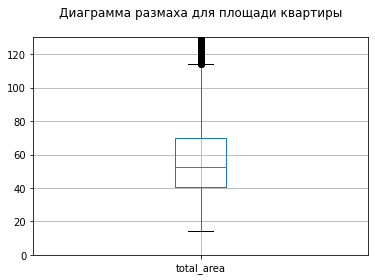

In [58]:
# Посмотрим на total_area
plt.ylim(0,130)
data.boxplot(column = 'total_area')
plt.title('Диаграмма размаха для площади квартиры' '\n')
plt.show()

In [59]:
# считаю процентиль
data['total_area'].quantile(0.005)

28.0

Меньше, чем у 0.5% квартир площадь меньше 28.2 квадратных метров, удалим такие наблюдения и удалим наблюдения с очень большими по площади квартирами.

Посмотрим теперь на распределение комнат.

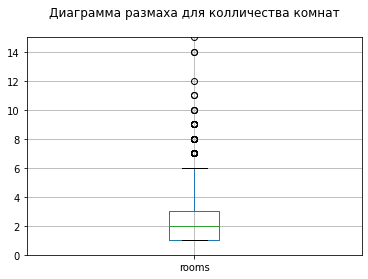

In [60]:
# строим диаграмму
plt.ylim(0,15)
data.boxplot(column = 'rooms')
plt.title('Диаграмма размаха для колличества комнат' '\n')
plt.show()

Начиная с 7 комнат квартиры уже становятся очень редкими. Посмотрим на такие квартиры, действительно ли они такие или это какая-то ошибка в данных.

In [61]:
# вывожу описательную статистику
data.query('rooms >6')['total_area'].describe().apply('{0:.2f}'.format)

count     78.00
mean     274.03
std      134.40
min      125.00
25%      191.92
50%      232.50
75%      332.20
max      900.00
Name: total_area, dtype: object

Оказывается, что это действительно очень большие квартиры, поэтому скорее всего тут никаких ошибок в данных нет и такие наблюдения соответствуют реальности, хоть и очень редки. Я удалю верхние хвосты в этих наблюдениях.


Теперь посмотрим на наблюдения с очень высокими потолками (>20м).

In [62]:
# вывожу наблюдения
data.query('ceiling_height>20')['ceiling_height']

2779     32.0
4103     25.0
4474     24.0
4628     27.0
4999     26.0
5122     27.0
5513     25.0
8311     25.0
9517     27.0
9974     25.0
12711    25.0
18061    27.0
18084    22.6
19690    32.0
20210    27.0
Name: ceiling_height, dtype: float64

Эти данные похохи на ошибки ввода - на самом деле потолки в 10 раз меньше.

In [63]:
# заменяю данные
data.loc[data['ceiling_height']>20,'ceiling_height'] = data['ceiling_height']/10

И последняя потенциально подозрительная переменная - это parks_nearest. Посмотрим на неё поподробнее.

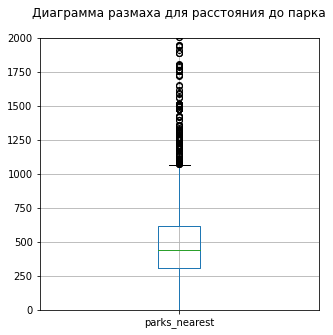

In [64]:
# рисую диаграмму
plt.figure(figsize = (5,5))
plt.ylim(0,2000)
plt.title('Диаграмма размаха для расстояния до парка' '\n')
data.boxplot(column = 'parks_nearest');


В данном примере у нас есть как и очень маленькие, так и очень большие значения. В целом, эти геаграфические данные кажутся не очень надёжными и потенциально возможно их вообще не стоит использовать. 
Я удалю все объявления, где квартиры находятся ближе к парку, чем 0.5% процентиль.

In [65]:
# удаляю хвосты в данных
data = data.query(
        '(days_exposition<@data["days_exposition"].quantile(0.999) or days_exposition.isna())'+
        'and (last_price>@data["last_price"].quantile(0.001) and last_price<@data["last_price"].quantile(0.999))'+
    'and (living_area>@data["living_area"].quantile(0.001) and living_area<@data["living_area"].quantile(0.999))'+
    'and (kitchen_area>@data["kitchen_area"].quantile(0.001) and kitchen_area<@data["kitchen_area"].quantile(0.999))'+
    'and (floors_total<@data["floors_total"].quantile(0.999))'+
    'and (ceiling_height<@data["ceiling_height"].quantile(0.999) and ceiling_height>@data["ceiling_height"].quantile(0.001))'+
    'and (parks_nearest>@data["parks_nearest"].quantile(0.001) or parks_nearest.isna())'+
    'and (rooms<@data["rooms"].quantile(0.999))'+
    'and (total_area>@data["total_area"].quantile(0.001) and total_area<@data["total_area"].quantile(0.995))'
    ).reset_index(drop = True)



В этой части я обработала данные: где было возможным, заменила пропуски, поменяла типы данных, удалила некоторые выбросы. 

#### check gap

In [66]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20570 entries, 0 to 20569
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20570 non-null  int64         
 1   last_price            20570 non-null  int64         
 2   total_area            20570 non-null  float64       
 3   first_day_exposition  20570 non-null  datetime64[ns]
 4   rooms                 20570 non-null  int64         
 5   ceiling_height        20570 non-null  float64       
 6   floors_total          20570 non-null  int64         
 7   living_area           20570 non-null  float64       
 8   floor                 20570 non-null  int64         
 9   is_apartment          20570 non-null  bool          
 10  studio                20570 non-null  bool          
 11  open_plan             20570 non-null  bool          
 12  kitchen_area          20570 non-null  float64       
 13  balcony         

### Посчитайте и добавьте в таблицу новые столбцы

In [76]:
# Добавляю новые переменные
data['square_price'] = data['last_price']/data['total_area']
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [77]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20570 entries, 0 to 20569
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20570 non-null  int64         
 1   last_price            20570 non-null  int64         
 2   total_area            20570 non-null  float64       
 3   first_day_exposition  20570 non-null  datetime64[ns]
 4   rooms                 20570 non-null  int64         
 5   ceiling_height        20570 non-null  float64       
 6   floors_total          20570 non-null  int64         
 7   living_area           20570 non-null  float64       
 8   floor                 20570 non-null  int64         
 9   is_apartment          20570 non-null  bool          
 10  studio                20570 non-null  bool          
 11  open_plan             20570 non-null  bool          
 12  kitchen_area          20570 non-null  float64       
 13  balcony         

In [78]:
# создаю функцию и добавляю новую переменную
def floor_type(row):
    try:
        if row['floor']==1:
            return 'Первый'
        elif row['floor']==row['floors_total']:
            return 'Последний'
        else:
            return 'Другой'
    except:
        pass
    
data['floor_type'] = data.apply(floor_type, axis=1)

In [79]:
# Переведём в км
data['city_centers_km']=(data['city_centers_nearest']/1000).round()

В данном разделе я добавила новые переменные, которые пригодятся в исследовательском анализе.

### Проведите исследовательский анализ данных

#### Изучение переменных

##### Общая площадь

Изучу общую площадь квартир.

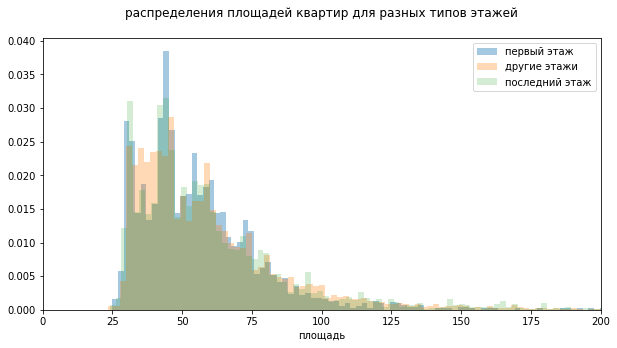

In [80]:
# строю гистрограммы общей площади для квартир на разных этажах
plt.figure(figsize = (10,5))
(plt.hist(data[data['floor_type']=='Первый']['total_area'], bins = 100, alpha=0.4, 
          label = 'первый этаж', density = True))
(plt.hist(data[data['floor_type']=='Другой']['total_area'], bins = 100, alpha=0.3, 
          label = 'другие этажи', density = True))
(plt.hist(data[data['floor_type']=='Последний']['total_area'], bins = 100, alpha=0.2, 
          label = 'последний этаж', density = True))
plt.xlim([0, 200])
plt.xlabel('площадь')
plt.title('распределения площадей квартир для разных типов этажей' '\n')
plt.legend(loc = 'upper right')

plt.show()

Распределение площадей квартир на разных этажах довольно похоже, хотя на последних этажах как будто чуть больше квартир большей площади.В среднем на всех этажах наиболее часто встречаются квартиры 35-45$м^2$

Посмотрим на распределение площадей квартир в зависимости от колличества комнат.

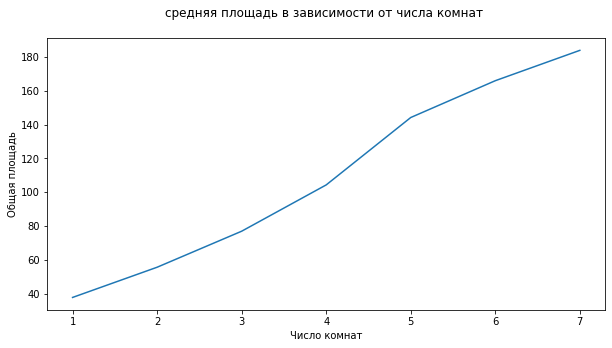

In [81]:
# строю график
(data.groupby('rooms')['total_area'].mean().plot(ylabel = 'Общая площадь', 
                                                 xlabel = 'Число комнат', figsize = (10,5), 
                                                 title = 'средняя площадь в зависимости от числа комнат \n'));

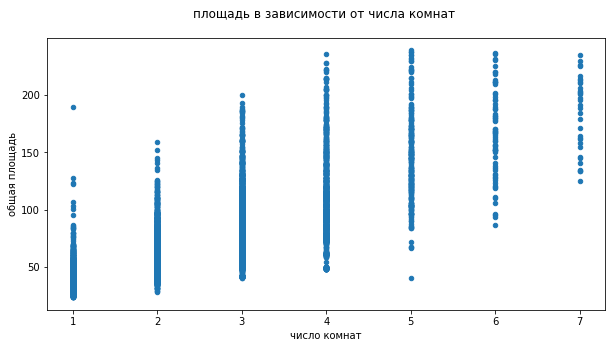

In [82]:
# Строю scatter plot
(data.plot(x = 'rooms', y = 'total_area', kind = 'scatter', figsize = (10,5),
           title = 'площадь в зависимости от числа комнат \n', xlabel = 'число комнат', ylabel = 'общая площадь'));

Как видно из обоих графиков есть четкий тренд, что квартиры с большим числом комнат в среднем больше. 

##### Жилая площадь

Теперь посмотрим на жилую площадь и площадь кухни.

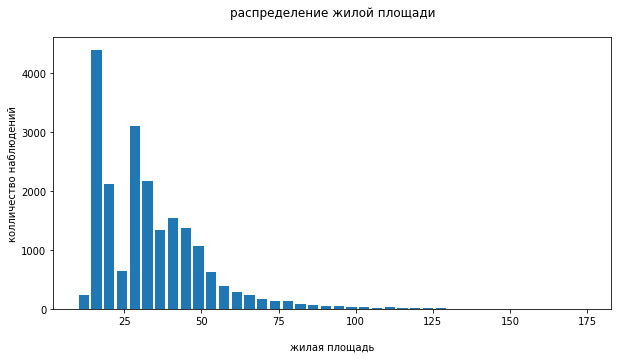

In [83]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['living_area'], bins = 40, rwidth = 0.8);
plt.xlabel('\n' 'жилая площадь')
plt.ylabel('колличество наблюдений')
plt.title('распределение жилой площади' '\n');


Интересено, откуда возникает второй пик в распределении. Посмотрю на гистограммы по числе комнат.

In [84]:
# считаю моду
data['living_area'].mode()

0    18.0
dtype: float64

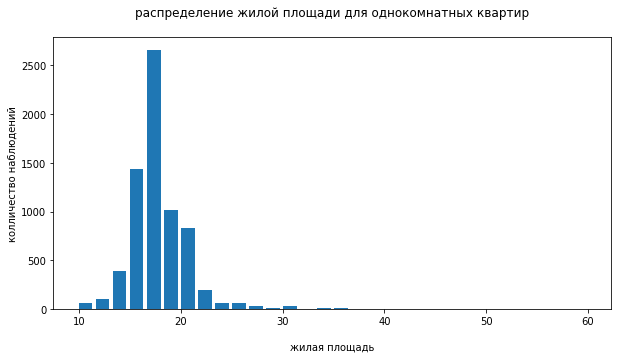

In [85]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.query('rooms ==1')['living_area'], bins = 30, rwidth = 0.8);
plt.xlabel('\n' 'жилая площадь')
plt.ylabel('колличество наблюдений')
plt.title('распределение жилой площади для однокомнатных квартир' '\n');


In [86]:
# считаю моду для подвыборки
data.query('rooms ==1')['living_area'].mode()

0    18.0
dtype: float64

Самые частые однокомнатные квартиры - с жилой площадью 18$м^2$, это же и в целом самая популярная жилая площадь. 

Теперь посмотрю на остальные квартиры

In [87]:
# считаю моду
data.query('rooms>1')['living_area'].mode()

0    30.0
dtype: float64

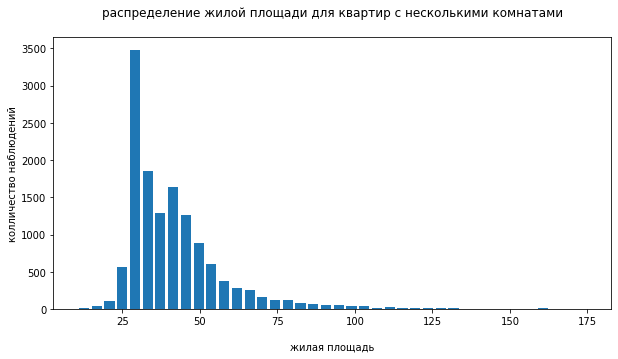

In [88]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.query('rooms>1')['living_area'], bins = 40, rwidth = 0.8);
plt.xlabel('\n' 'жилая площадь')
plt.ylabel('колличество наблюдений')
plt.title('распределение жилой площади для квартир с несколькими комнатами' '\n');


Для всех других квартир кроме однокомнатных самый популярный размер жилой площади - 30 $м^2$.

Посмотрим, какая доля всех квартир - однокомнатные.

In [89]:
# доля однокомнатных
data.query('rooms==1')['living_area'].count()/data['living_area'].count()

0.33825960136120564

Больше трети квартир в выборке - однокомнатные, в итоге общее распределение жилой площади выглядит практически как бимодальное. 

##### Площадь кухни

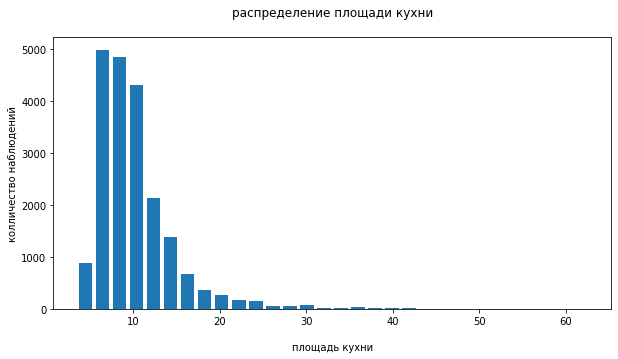

In [90]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['kitchen_area'], bins = 30, rwidth = 0.8);
plt.xlabel('\n' 'площадь кухни')
plt.ylabel('колличество наблюдений')
plt.title('распределение площади кухни' '\n');


Разброс значений в жилой прощади больше, чем в площади кухни. Посмотрим на корреляцию между этими двумя значениями.

In [91]:
# считаю корреляцию
data['living_area'].corr(data['kitchen_area'])

0.35718362260696884

Между этими площадями есть положительная корреляция, что довольно логично: скорее всего у больших квартир больше и площадь жилой поверхности и площадь кухни.

##### Цена

На этапе знакомства с данными, мы нашли логарифм цены, потому что цена имеет очень большой разброс.

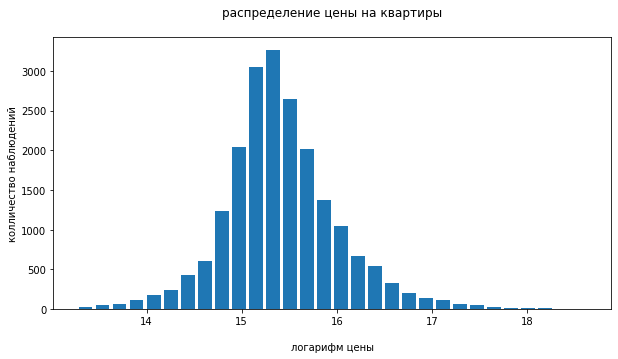

In [92]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['log_last_price'], bins = 30, rwidth = 0.8);
plt.xlabel('\n' 'логарифм цены')
plt.ylabel('колличество наблюдений')
plt.title('распределение цены на квартиры' '\n');

Распределение действительно похоже на лог-нормальное.

##### Колличество комнат

Посмотрим на распределение числа комнат.

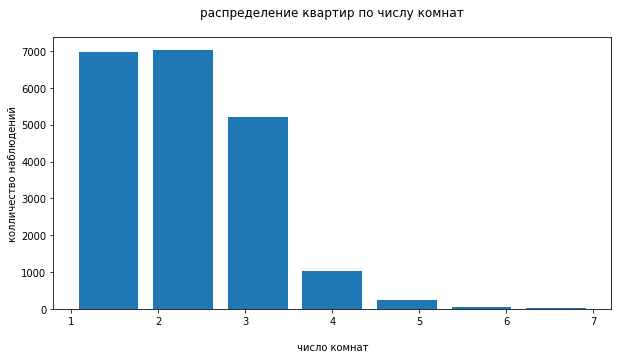

In [93]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['rooms'], bins = 7, rwidth = 0.8);
plt.xlabel('\n' 'число комнат')
plt.ylabel('колличество наблюдений')
plt.title('распределение квартир по числу комнат' '\n');


Чаще всего встречаются двухкомантные квартиры, причём есть резкое падение в числе объявлений, как только комнат становится больше трёх.

In [94]:
# считаю процент квартир
round(100*data.query('rooms<4 & rooms>0')['rooms'].count()/data.shape[0])

93

Действительно, почти что 93% объявлений - о продаже квартир с 1, 2 и 3 комнатами.

##### Высота потолков

Распределение высоты потолков я уже посмотрела на этапе заполнения пропусков, когда проверяла, что алгоритм knn адекватно заполнил пропуски. Посмотрим ещё раз на него.

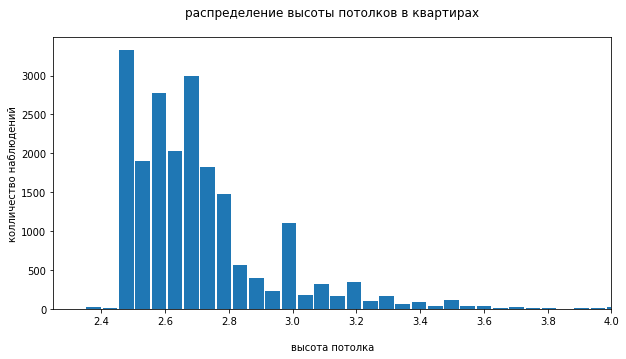

In [95]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['ceiling_height'], bins = 100, rwidth = 0.9);
plt.xlabel('\n' 'высота потолка')
plt.ylabel('колличество наблюдений')
plt.xlim(2.25,4)
plt.title('распределение высоты потолков в квартирах' '\n');


##### Этаж квартир

Теперь посмотрю на распределение объявлений квартир по этажам.

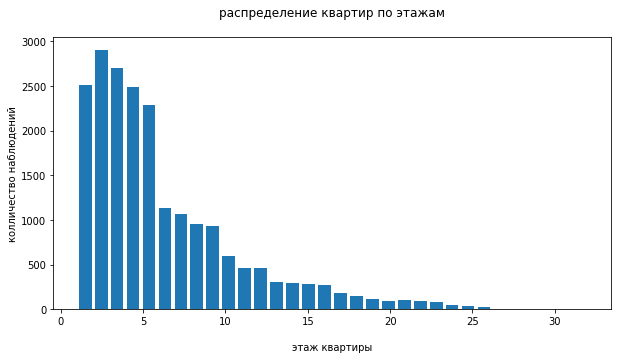

In [96]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['floor'], bins = 32, rwidth = 0.8);
plt.xlabel('\n' 'этаж квартиры')
plt.ylabel('колличество наблюдений')
plt.title('распределение квартир по этажам' '\n');


Большинство квартир продаётся на нижних этажах (до 5). Теперь посмотрим, как часто продающиеся квартиры бывают на первом, последнем или серединном этаже.

##### Тип этажа 

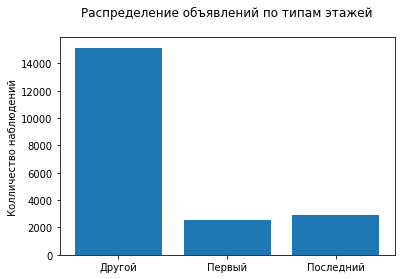

In [97]:
# строю столбчатую диаграмму
fig, ax = plt.subplots()

ax.bar(data.groupby('floor_type')['floor_type'].count().index, data.groupby('floor_type')['floor_type'].count());
plt.ylabel('Колличество наблюдений');
plt.title('Распределение объявлений по типам этажей' '\n');

Естественно больше всего квартир продаётся не на первом и не на последнем этаже (просто потому что не первых и не последних этажей больше). Было бы скорее странно, если бы это оказалось не так. 

##### Этажность зданий

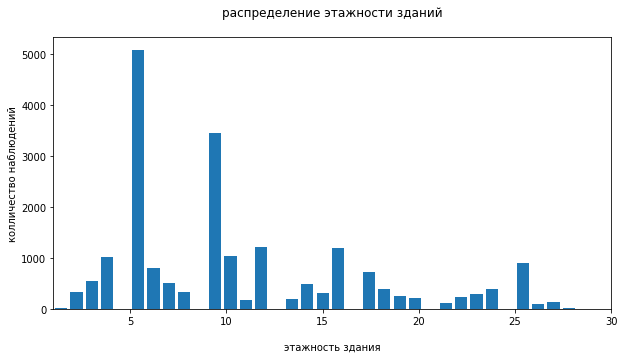

In [98]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['floors_total'], bins = 40, rwidth = 0.8);
plt.xlabel('\n' 'этажность здания')
plt.ylabel('колличество наблюдений')
plt.xlim(1,30)
plt.title('распределение этажности зданий' '\n');


In [99]:
# считаю моду
data['floors_total'].mode()

0    5
dtype: int64

In [100]:
# считаю вторую моду
data.query('floors_total!=5')['floors_total'].mode()

0    9
dtype: int64

Распределение этажности домов тоже выглядит адекватно, с пиками в этажности в 5 и 9 этажей. 

##### Расстрояние до центра города

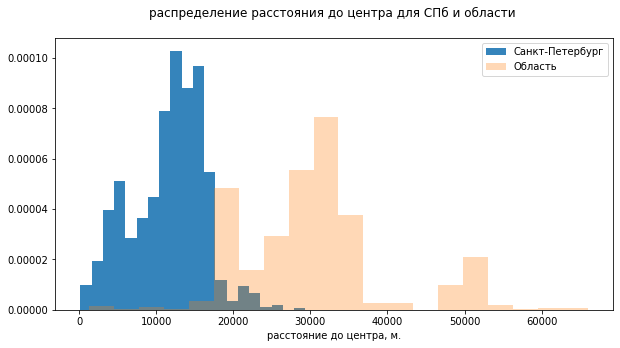

In [101]:
# Строю гистограмму
plt.figure(figsize = (10,5))
(plt.hist(data.query('locality_type =="Санкт-Петербург" and city_centers_nearest.notna()')['city_centers_nearest'], 
          bins = 20, alpha=0.9, label = 'Санкт-Петербург', density = True))
(plt.hist(data.query('locality_type =="Область" and city_centers_nearest.notna()')['city_centers_nearest'], 
          bins = 20, alpha=0.3, label = 'Область', density = True))
plt.legend(loc = 'upper right')
plt.xlabel('расстояние до центра, м.')
plt.title('распределение расстояния до центра для СПб и области \n')
plt.show()

Видно, что квартиры в Санкт-Петербурге стохастически значительно ближе к центру, чем квартиры в области.

##### Расстрояние до аэропорта

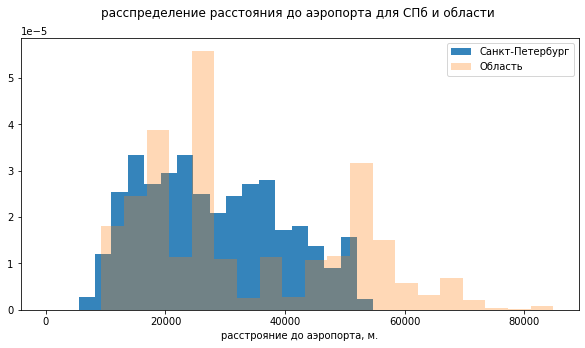

In [102]:
# Строю гистограмму
plt.figure(figsize = (10,5))
(plt.hist(data.query('locality_type =="Санкт-Петербург" and airports_nearest.notna()')['airports_nearest'],
          bins = 20, alpha=0.9, label = 'Санкт-Петербург', density = True))
(plt.hist(data.query('locality_type =="Область" and airports_nearest.notna()')['airports_nearest'], 
          bins = 20, alpha=0.3, label = 'Область', density = True))
plt.legend(loc = 'upper right')
plt.xlabel('расстрояние до аэропорта, м.')
plt.title('расспределение расстояния до аэропорта для СПб и области \n')
plt.show()

Квартира в Санкт-Петербурге более-менее равномерно распределены относительно удалённости от аэропорта с меньшим разбросом расстояний, в то время как в области распределение больше похоже на би(или три)модальное.

##### Расстрояние до парка

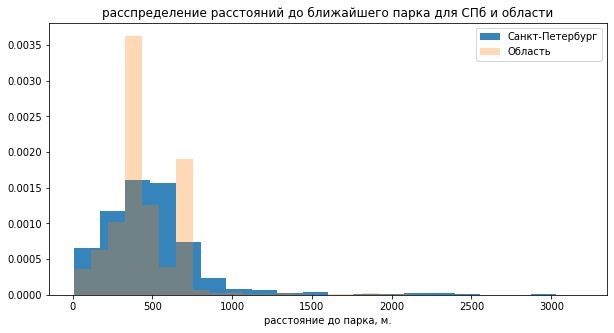

In [103]:
# Строю гистограмму
plt.figure(figsize = (10,5))
(plt.hist(data.query('locality_type =="Санкт-Петербург" and parks_nearest.notna()')['parks_nearest'], 
          bins = 20, alpha=0.9, label = 'Санкт-Петербург', density = True))
(plt.hist(data.query('locality_type =="Область" and parks_nearest.notna()')['parks_nearest'], 
          bins = 20, alpha=0.3, label = 'Область', density = True))
plt.legend(loc = 'upper right')
plt.xlabel('расстояние до парка, м.')
plt.title('расспределение расстояний до ближайшего парка для СПб и области')
plt.show()

Распределение расстояний до парков довольно похоже в Санкт-Петербурге и в области. Моды практически совпадают, но в области есть ещё и второй пик.

##### День, месяц и год публикации

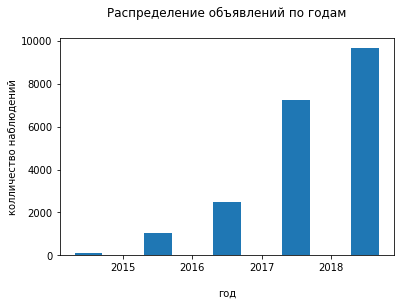

In [104]:
# строю гистограмму
fig, ax = plt.subplots()

ax.hist(data['first_day_exposition'].dt.year, bins = 5, rwidth = 0.4)

ax.set_title('Распределение объявлений по годам' '\n')

ax.set_xlabel('\n' 'год')
ax.set_ylabel('колличество наблюдений')

plt.show()

Видно, что колличество объявлений сильно увличилось со временем.

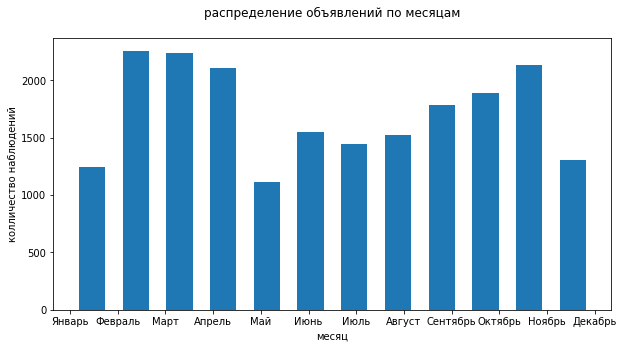

In [105]:
# гистограмма
plt.figure(figsize = (10,5));
plt.hist(data['first_day_exposition'].dt.month, bins = 12, rwidth = 0.6);
plt.xlabel('месяц')
plt.title('распределение объявлений по месяцам' '\n')
plt.ylabel('колличество наблюдений')
plt.grid(visible = False);
(plt.xticks([1,2,3,4,5,6,7,8,9,10,11, 12], 
            ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 
             'Ноябрь', 'Декабрь']));

Похоже, что на праздниках есть определённое затишье: в декабре, январе и мае объявлений меньше, а в феврале (самом коротком месяце) очень большое число объявлений. Возможно, это как раз объясняется тем, что все те, кто были готовы выставить свои объявления ещё в декабре и январе и отложили из-за праздников, смогли это наконец сделать.

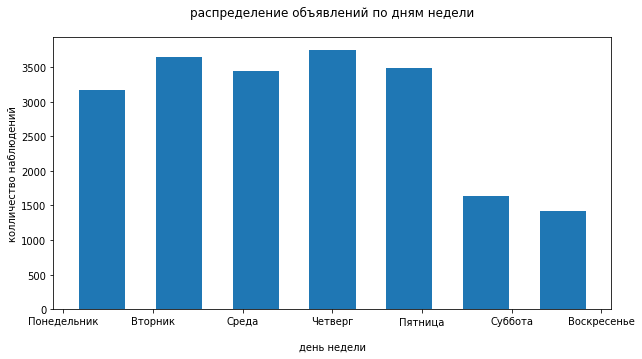

In [106]:
# Нарисуем гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['first_day_exposition'].dt.weekday, bins = 7, rwidth = 0.6)
plt.grid(visible = False)
plt.xlabel('\n' 'день недели')
plt.ylabel('колличество наблюдений')
plt.title('распределение объявлений по дням недели' '\n')
(plt.xticks([0,1,2,3,4,5,6],
            ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']));

Снова видим, но выходных снижение активности по подаче объявлений.

Распределение дней и месяцев публикации я уже рассмотрела на этапе знакомства с данными и увидела, что есть снижение объявлений во время празников и выходных. 

#### Изучение скорости продажи

Посмотрим на распределение days_exposition

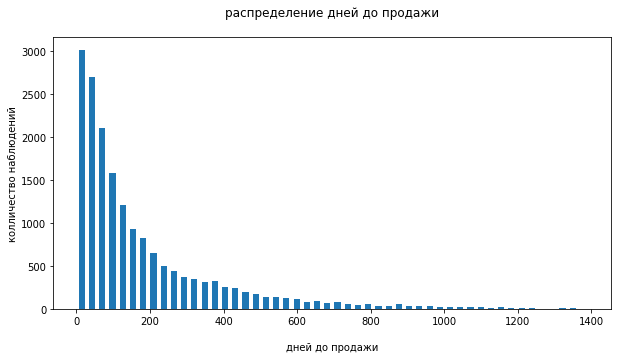

In [107]:
# Нарисуем гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['days_exposition'], bins = 50, rwidth = 0.6)
plt.xlabel('\n' 'дней до продажи')
plt.ylabel('колличество наблюдений')
plt.title('распределение дней до продажи' '\n');

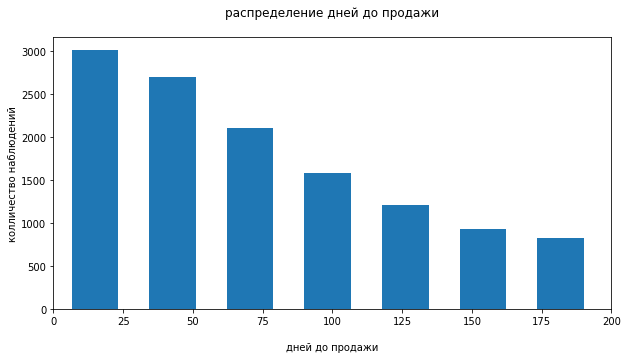

In [108]:
# Нарисуем гистограмму 2
plt.figure(figsize = (10,5))
plt.hist(data['days_exposition'], bins = 50, rwidth = 0.6)
plt.xlim(0,200)
plt.xlabel('\n' 'дней до продажи')
plt.ylabel('колличество наблюдений')
plt.title('распределение дней до продажи' '\n');

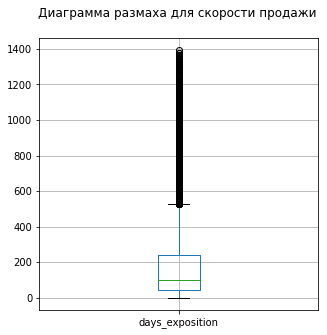

In [109]:
# Строю диаграмму
plt.figure(figsize = (5,5))
plt.title('Диаграмма размаха для скорости продажи \n')
data.boxplot(column = 'days_exposition');

Исходя из диаграммы, практически не видно отдельных слишком быстрых продаж, но есть много отдельных слишком долгих продаж (больше 547 дней). Посмотрим на описательную статистику.

In [110]:
# считаем описательную статистику
data['days_exposition'].describe().apply('{0:.2f}'.format)

count    17741.00
mean       183.85
std        217.53
min          1.00
25%         45.00
50%        102.00
75%        238.00
max       1391.00
Name: days_exposition, dtype: object

В сраднем квартиры продавались 184 дня, причём четветь квартир продавалась за 1.5 месяца. Посмотрим на 2.5% и 97.5%.

In [111]:
# считаю процентили для времени продажи
print(data['days_exposition'].quantile(0.025))
data['days_exposition'].quantile(0.975)

6.000000000000001


842.5

Всего 2.5% объявлений продали квартиру быстрее, чем ха 6 дней. И всего 2.5% квартир продали дольше чем, за 842.5 дня (больше двух лет). При этом четверть квартир продавались быстрее, чем за 45 дней - это быстрые продажи. И четверть квартир продавались дольше 238 дней - это долгие продажи.

Посмотрим на среднюю скорость продаж по годам.

In [112]:
# смотрю на среднее по годам
data.groupby('year')['days_exposition'].mean().apply('{0:.2f}'.format)

year
2014    864.19
2015    640.82
2016    323.46
2017    160.39
2018     97.54
2019     31.04
Name: days_exposition, dtype: object

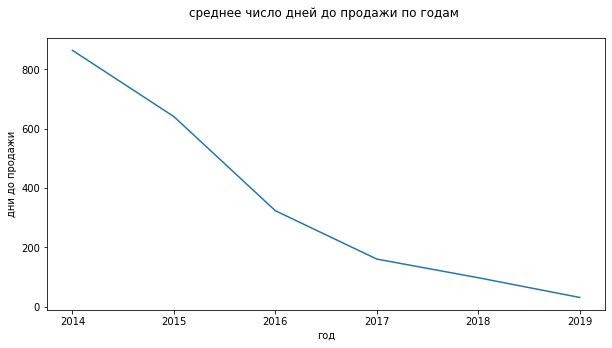

In [113]:
# Посмотрим график
(data.groupby('year')['days_exposition'].mean()
 .plot(figsize = (10,5), xlabel = 'год', ylabel = 'дни до продажи',
       title = 'среднее число дней до продажи по годам \n'));

Интересно, что с течением времени квартиры стали продаваться быстрее. 

In [114]:
# считаю моду
data['days_exposition'].mode()

0    45.0
dtype: float64

Самое частое время до продажи - это 45 дней.

В Санкт-Петербурге и области бесплатное объявление может висеть полгода, а платное надо оплачивать каждые 30 дней. Посмотрим, есть ли скачки продаж перед концом этих периодов.

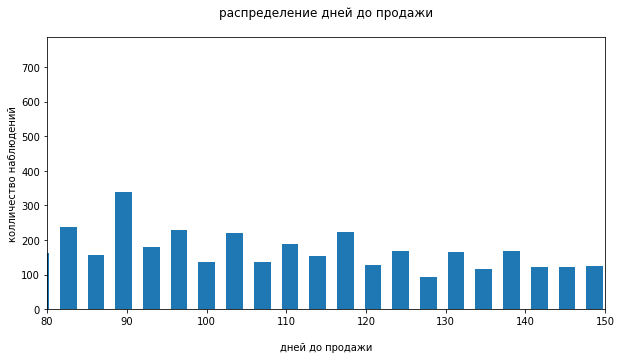

In [115]:
# Нарисуем гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['days_exposition'], bins = 400, rwidth = 0.6)
plt.xlim(80,150)
plt.xlabel('\n' 'дней до продажи')
plt.ylabel('колличество наблюдений')
plt.title('распределение дней до продажи' '\n');

Не похоже, чтобы была какая-то аномалия около 120 дней.

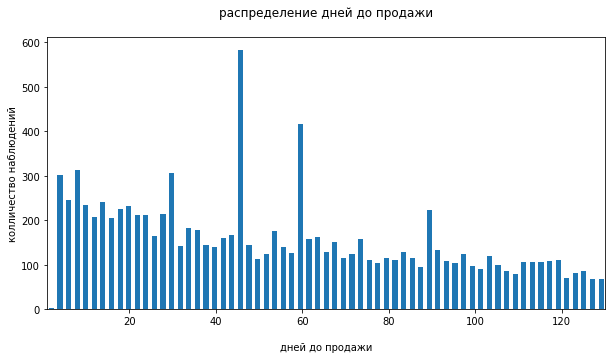

In [116]:
# Нарисуем гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['days_exposition'], bins = 700, rwidth = 0.6)
plt.xlim(1,130)
plt.xlabel('\n' 'дней до продажи')
plt.ylabel('колличество наблюдений')
plt.title('распределение дней до продажи' '\n');

Действительно, хоть есть и основная мода в 45 дней, которую сложно объяснить текущими условиями размещения объявления, видны определённые скачки в продажах каждые 30 дней, что может быть связано с желанием завершить сделку до наступления нового периода оплаты объявления. 

#### Стоимость квартиры

Теперь изучим факторы, которые влияют на стоимоть квартиры. Для начала изучим матрицу корреляций. 

In [118]:
# считаю матрицу корреляций
(data[['last_price', 'total_area', 'living_area', 'kitchen_area', 
       'rooms','weekday', 'month', 'year', 'floor']].corr())

,last_price,total_area,living_area,kitchen_area,rooms,weekday,month,year,floor
last_price,1.000000,0.734431,0.637194,0.553824,0.448847,-0.006115,0.003130,-0.044710,0.048699
total_area,0.734431,1.000000,0.932167,0.582680,0.792517,-0.007476,0.005109,-0.085150,-0.017185
living_area,0.637194,0.932167,1.000000,0.357184,0.874328,-0.005053,-0.000580,-0.071358,-0.104172
kitchen_area,0.553824,0.582680,0.357184,1.000000,0.220615,-0.009733,0.007403,-0.055032,0.159634
rooms,0.448847,0.792517,0.874328,0.220615,1.000000,-0.000260,-0.002061,-0.050478,-0.148606
weekday,-0.006115,-0.007476,-0.005053,-0.009733,-0.000260,1.000000,0.008447,-0.006982,0.006950
month,0.003130,0.005109,-0.000580,0.007403,-0.002061,0.008447,1.000000,-0.255486,0.017350
year,-0.044710,-0.085150,-0.071358,-0.055032,-0.050478,-0.006982,-0.255486,1.000000,0.009056
floor,0.048699,-0.017185,-0.104172,0.159634,-0.148606,0.006950,0.017350,0.009056,1.000000


У цены есть положительная корреляция со всеми показателями площади (но тут важно помнить, что разные площади сами очень сильно скоррелированы друг с другом), с колличеством комнат (которое тоже скоррелировано с площадью, поэтому не факт, что комнаты будут влиять на стоимость сами по себе). У цены практически нет корреляции с днём недели, месяцем и годом в которые было размещено объявление.

Посмотрим тренд цен по годам

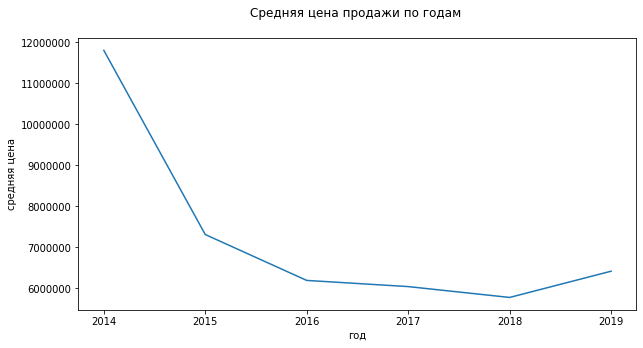

In [124]:
# строю график
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.groupby('year')['last_price'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xticks([0,1,2,3,4,5], ['2014', '2015', '2016', '2017', '2018', '2019']);
plt.xlabel('год')
plt.ylabel('средняя цена')
plt.title('Средняя цена продажи по годам \n')
plt.show()

В 2014 были высокие цены на квартиры, далее цены падают, хот я в 2019 году есть небольшое повышение среднего.

Посмотрим повнимательнее на 2014 года в сравнении с остальными.

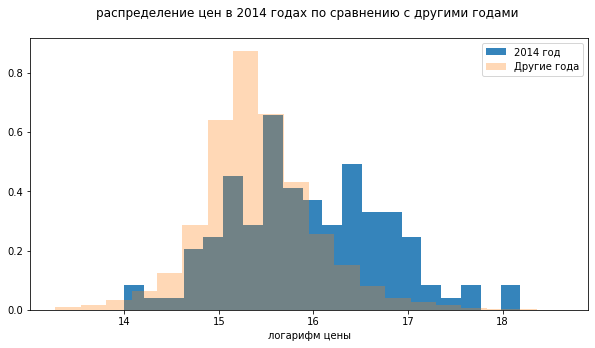

In [125]:
# Строю гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.query('year == 2014')['log_last_price'], bins = 20, alpha=0.9, label = '2014 год', density = True)
plt.hist(data.query('year!= 2014')['log_last_price'], bins = 20, alpha=0.3, label = 'Другие года', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('логарифм цены')
plt.title('распределение цен в 2014 годах по сравнению с другими годами \n')
plt.show()

Действительно в 2014 года продалось больше дорогих квартир, посмотрим, связано ли это с площадями квартир, которые продавались в 2014 году. 

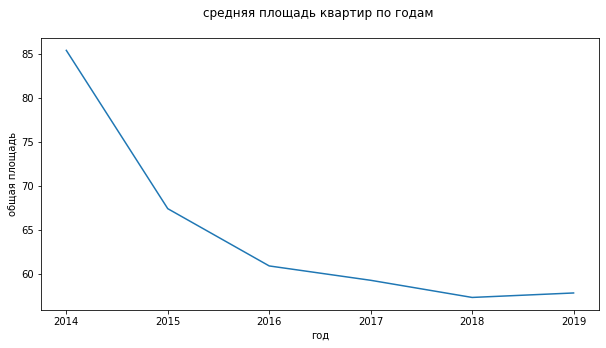

In [126]:
# график
(data.groupby('year')['total_area'].mean()
 .plot(figsize = (10,5), xlabel = 'год', ylabel = 'общая площадь', title = 'средняя площадь квартир по годам \n'));

Действительно тренд средней площади продающихся квартир по годам повторяет тренд со средней ценой. Не год влияет сам по себе, а характеристики квартир, продающихся в эти года.

Посмотрим на связь цены и днями недели, когда размещено объявление и месяциёами.

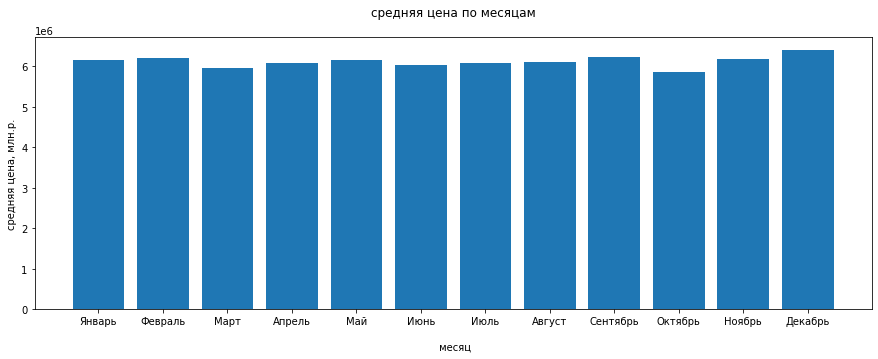

In [127]:
# гистограмма
plt.figure(figsize = (15,5));
plt.bar(data.groupby('month')['last_price'].mean().index,data.groupby('month')['last_price'].mean());
plt.xlabel('\n месяц')
plt.title('средняя цена по месяцам' '\n')
plt.ylabel('средняя цена, млн.р.')
plt.grid(visible = False);
(plt.xticks([1,2,3,4,5,6,7,8,9,10,11, 12], 
            ['Январь', 'Февраль', 'Март', 'Апрель', 
             'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']));

Не похоже, чтобы средняя стоимость квартиры сильно зависила от месяца подачи объявления.
Теперь посмотрим на связь цены с днём недели.

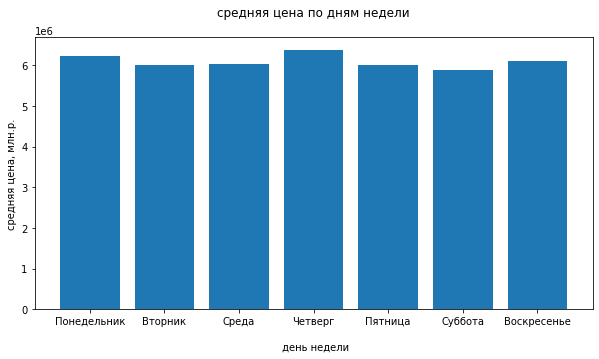

In [128]:
# гистограмма
plt.figure(figsize = (10,5));
plt.bar(data.groupby('weekday')['last_price'].mean().index,data.groupby('weekday')['last_price'].mean());
plt.xlabel('\n день недели')
plt.title('средняя цена по дням недели' '\n')
plt.ylabel('средняя цена, млн.р.')
plt.grid(visible = False);
(plt
 .xticks([0,1,2,3,4,5,6], ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']));

Здесь тоже на первый взгляд не видно значимой разницы.

Посмотрим, есть ли взаимосвязь цены с типом этажа.

In [129]:
# средняя цена для типа этажа
data.groupby('floor_type')['last_price'].mean()

floor_type
Другой       6.362763e+06
Первый       4.689715e+06
Последний    6.027734e+06
Name: last_price, dtype: float64

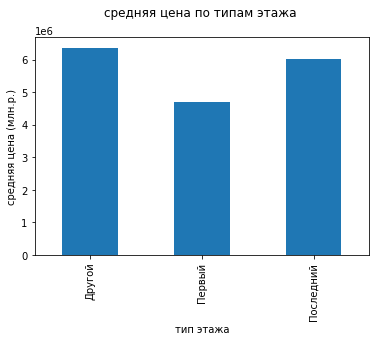

In [130]:
# столбчатая диаграмма
(data
 .groupby('floor_type')['last_price'].mean()
 .plot(kind = 'bar', ylabel='средняя цена (млн.р.)', xlabel = 'тип этажа', title = 'средняя цена по типам этажа \n'));

Первоначальный анализ показывает, что квартиры на первом этаже самые дешевые, а на последнем - самые дорогие. Но мы не знаем, насколко это статистически значимое различие.

Посмотрим теперь на диаграммы рассеянья между ценой и переменными, с которыми мы увидели положительную корреляцию.

In [131]:
# Создаём случайнвый шум для дольшей наглядности графика
noise = np.random.normal(0, 2, size=len(data['total_area']))
total_area_jitter = data['total_area'] + noise
living_area_jitter = data['living_area']+noise
kitchen_area_jitter = data['kitchen_area']+noise

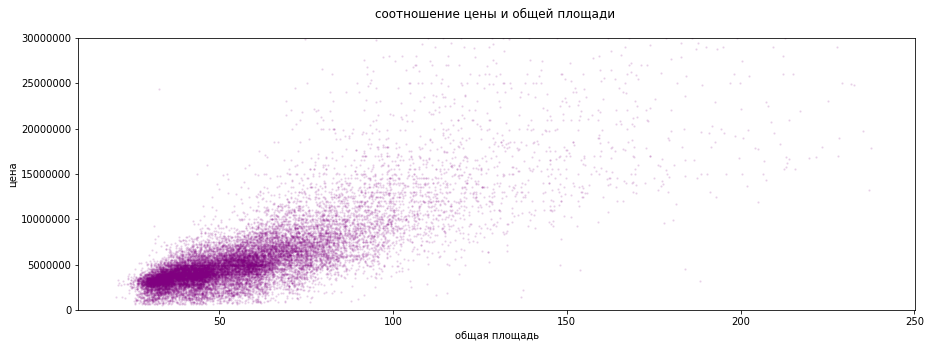

In [132]:
# диаграмма рассеяния
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
plt.scatter(total_area_jitter, data['last_price'], s= 2, marker = 'o', c = [[0.5, 0, 0.5, 0.1]])
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('общая площадь')
plt.ylabel( 'цена')
plt.title('соотношение цены и общей площади \n')
plt.ylim(0, 30000000)
plt.show()

Видно, что есть положительный тренд.

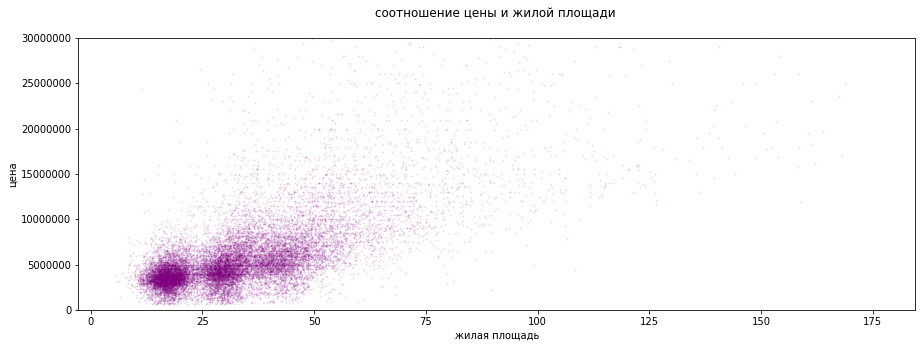

In [133]:
# диаграмма рассеяния
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
plt.scatter(living_area_jitter, data['last_price'], s = 1, marker = 'o', c = [[0.5, 0, 0.5, 0.1]])
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('жилая площадь')
plt.ylabel( 'цена')
plt.title('соотношение цены и жилой площади \n')
plt.ylim(0, 30000000)
plt.show()

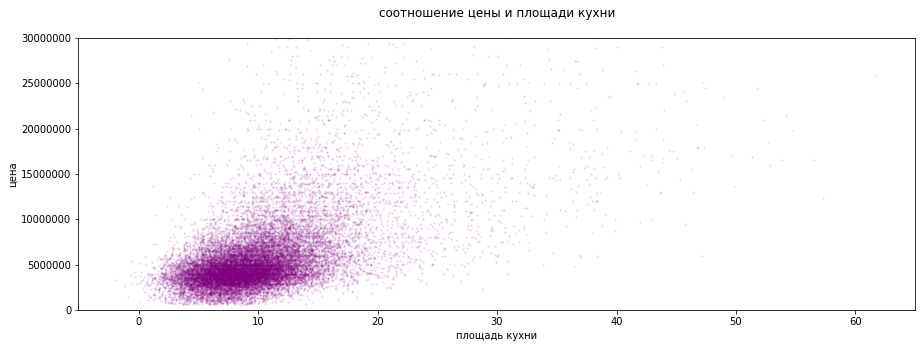

In [134]:
# диаграмма рассеяния
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
plt.scatter(kitchen_area_jitter, data['last_price'], s = 2, marker = 'o', c = [[0.5, 0, 0.5, 0.1]])
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('площадь кухни')
plt.ylabel( 'цена')
plt.title('соотношение цены и площади кухни\n')
plt.ylim(0, 30000000)
plt.show()

Картина для всех видов площадей очень похожа.

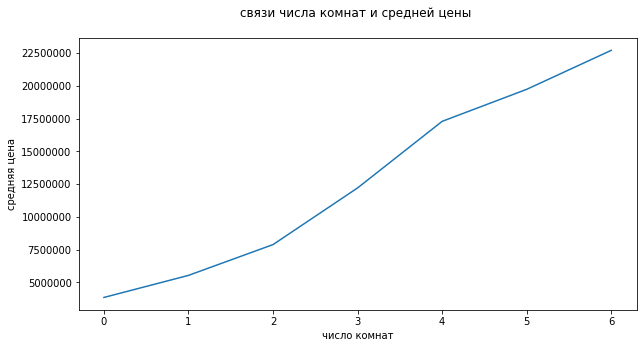

In [135]:
#связь числа комнат и средней цены
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.groupby('rooms')['last_price'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('число комнат')
plt.ylabel('средняя цена')
plt.title('связи числа комнат и средней цены \n')
plt.show()

Для того, чтобы понять, что влияет на стоимость квартир, оценим линейную регрессию. Для начала создадим бинарные переменные, что квартира на первом этаже и на последнем этаже

In [136]:
# создаем бинарные переменные
def first_floor(floor_type):
    if floor_type == 'Первый':
        return 1
    else:
        return 0

    
def last_floor(floor_type):
    if floor_type == 'Последний':
        return 1
    else:
        return 0
    
data['first_floor'] = data['floor_type'].apply(first_floor)
data['last_floor'] = data['floor_type'].apply(last_floor)

Теперь оценим регрессию.

In [137]:
# оцениваю линейную регрессию
x = (data[['total_area', 'living_area', 'kitchen_area', 'rooms', 'weekday', 'month', 'year', 'first_floor', 
           'last_floor']].astype(float))
y = data['last_price'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             last_price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     3335.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:23:33   Log-Likelihood:            -3.3999e+05
No. Observations:               20570   AIC:                         6.800e+05
Df Residuals:                   20560   BIC:                         6.801e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.576e+08   5.12e+07     -5.034   

Мы видим, что каждая из видов прощадей при прочих равных значимо увеличивае цену: например, при росте общей площади на 1$м^2$ при прочих равных цена квартиры возрастает в среднем на 166т.р. При этом число комнат, оказывается имеет отрицательное значимое влияние: при прочих равных квартира, где комнат на 1 больше будет стоить в среднем на 1.9 миллиона дешевле (но это при одинаковых метражах и остальных показателях). 

Квартиры на первом этаже в среднем на 629т.р. дешевле, а квартиры на последнем этаэе при прочих равных на 358т.р. дешевле.

После того, как я проконтролировала все остальные показатели, оказалось, что при прочих равных цены на квартиры росли в последнее время, каждый последующий год, такая же квартира стоила в среднем на 126т.р. больше. Негативный тренд, который был замечен в изначальных корреляциях, объяснялся характеристиками квартир, а не рынком жилья. 

#### Самые дорогие квадратные метры

Теперь посмотрим на населённые пункты с наибольшим числом продаж.

In [138]:
# список 10 населённых пунктов с наибольшим числом сделок
data.groupby('locality_name')['last_price'].count().sort_values(ascending = False).head(10)

locality_name
Санкт-Петербург      13778
поселок Мурино         423
поселок Шушары         390
Всеволожск             351
Пушкин                 330
Колпино                317
Гатчина                286
поселок Парголово      286
деревня Кудрово        224
Петергоф               188
Name: last_price, dtype: int64

In [139]:
# создаем словарь со средней ценой квадратного метра в данных локациях
expensive_list={}
for locality in data.groupby('locality_name')['last_price'].count().sort_values(ascending = False).head(10).index:
    expensive_list[locality] = data.query('locality_name == @locality')['square_price'].mean()
    

In [140]:
# сортируем данные
expensive = (pd.DataFrame([expensive_list]).T.rename(columns = {0: 'square_price'})
 .sort_values(by = 'square_price', ascending = False))
expensive.style.format('{:,.0f}')

,square_price
Санкт-Петербург,"112,461"
Пушкин,"103,317"
деревня Кудрово,"92,199"
поселок Парголово,"90,631"
поселок Мурино,"85,198"
Петергоф,"83,835"
поселок Шушары,"78,595"
Колпино,"75,305"
Всеволожск,"68,979"
Гатчина,"68,506"


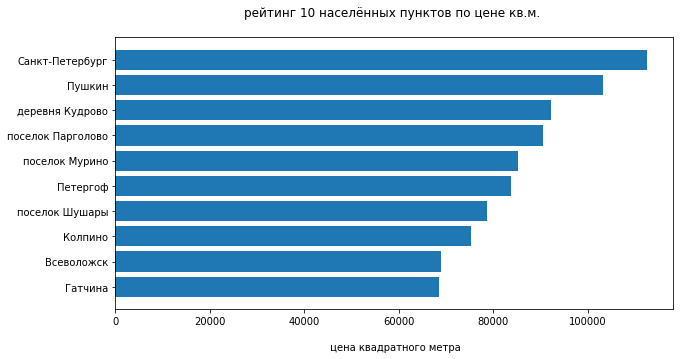

In [141]:
# расуем столбчатую диаграмму
fig, ax = plt.subplots()
plt.barh(expensive.sort_values(by = 'square_price').index, expensive['square_price'].sort_values());
fig.set_size_inches(10,5)
plt.xlabel('\n цена квадратного метра');
plt.title('рейтинг 10 населённых пунктов по цене кв.м. \n');

Из 10 населённых пунктов с самым большим колличеством сделок самая дорогая недвижимости в Санкт-Петербурге, Пушкине и Парголово. В то время как самая дешёвая в Гатчике и Выборге.

#### Стоимость километров в СПб

Теперь посмотрим на стоимость разных километров в Санкт-Петербурге.

In [142]:
# считаем среднюю цену для каждого километра
data.query('locality_name=="Санкт-Петербург"').groupby('city_centers_km')['last_price'].mean().apply('{0:.0f}'.format)

city_centers_km
0.0     21825154
1.0     15438681
2.0     15116339
3.0     10151812
4.0     11041655
5.0     11750612
6.0     12417170
7.0     13201795
8.0      9079113
9.0      6978750
10.0     6297821
11.0     6166827
12.0     5866545
13.0     6072844
14.0     5565007
15.0     5824134
16.0     5375248
17.0     5276051
18.0     4988425
19.0     5124521
20.0     4876000
21.0     5158881
22.0     5249723
23.0     5041707
24.0     3913091
25.0     4312500
26.0     4021500
27.0     8300000
28.0     5026429
29.0     4594000
Name: last_price, dtype: object

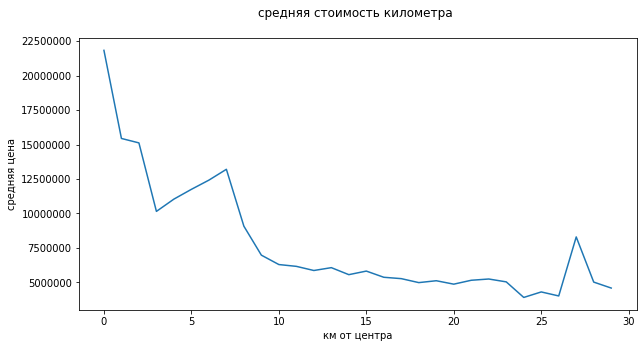

In [143]:
# строю график зависимости средней цены от км
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.query('locality_name=="Санкт-Петербург"').groupby('city_centers_km')['last_price'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('км от центра')
plt.ylabel('средняя цена')
plt.title('средняя стоимость километра \n')
plt.show()

В целом виден тренд, что чем дальше квартира от центра города в Санкт-Петербурге, тем дешеве она стоит.

Посмотрим на записи на 27ом километре

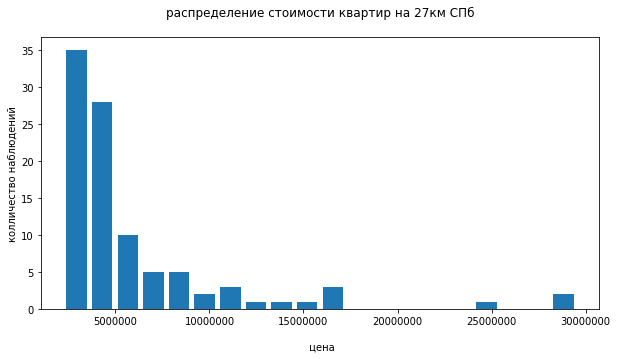

In [144]:
plt.figure(figsize = (10,5));
plt.hist(data.query('city_centers_km == 27')['last_price'], bins = 20, rwidth = 0.8);
plt.xlabel('\n цена')
plt.title('распределение стоимости квартир на 27км СПб' '\n')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('колличество наблюдений')
plt.grid(visible = False);


На гистограмме виднго, что есть насколько объявлений с значительно более дорогими квартирами. Для сравнения посмотрим на 26ой км.

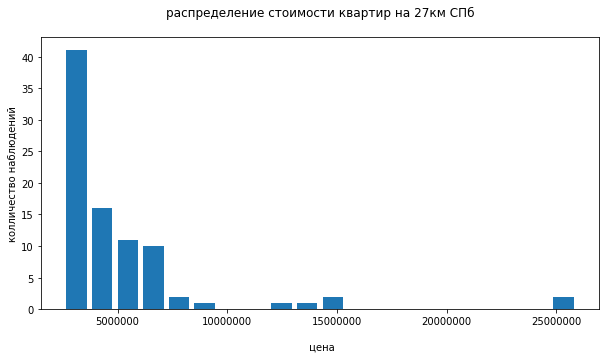

In [145]:
plt.figure(figsize = (10,5));
plt.hist(data.query('city_centers_km == 26')['last_price'], bins = 20, rwidth = 0.8);
plt.xlabel('\n цена')
plt.title('распределение стоимости квартир на 27км СПб' '\n')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('колличество наблюдений')
plt.grid(visible = False);


Тут тоже есть выбивающиеся наблюдения, но их меньше и они не такие дорогие.

На самом деле практически все объявления, находящиеся на расстоянии более 20 км от центра СПб уже являются проблематичными и их не стоит рассматривать. Если посмотреть на карту, 20 км от центра СПб уже покрывает такие населенные пункты, как Пушкин и Петергоф, которые административно являются частью города Санкт-Петербург, 27 км от центра это уже расстояние по воде до Кронштадта, который тоже является частью города Санкт-Петербург. В наших данных эти города присутствуют как отдельные названия в locality_name, потому что некоторые авторы объявлений резонно указали их. Но в наших же данных есть и locality_name Санкт-Петербург с расстоянием более 20 км от центра, и данные наблюдения на самом деле тоже принадлежат городам и посёлкам, входящим в состав города Санкт-Петербурги, но без дополнительной информации, мы не можем точно узнать, каким именно. 

Посмотрим теперь на квартиры на 3м и 5м километре. У нас виден провал в цене на 3м км и рост на 5-7 км. 

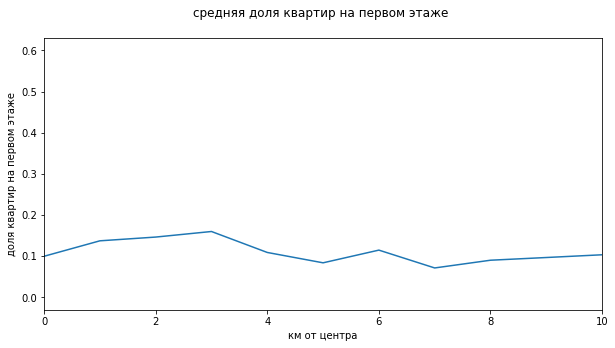

In [146]:
# строю график 
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.query('locality_name=="Санкт-Петербург"').groupby('city_centers_km')['first_floor'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 10)
plt.xlabel('км от центра')
plt.ylabel('доля квартир на первом этаже')
plt.title('средняя доля квартир на первом этаже \n')
plt.show()

есть небольшой рост доли квартир на первом этаже не 3ьем километре и небольшое падение этой доли на 5м. Квартиры на первом этаже в среднем более дешевые, это может объяснить некоторую разницу в ценах, хотя изменения не кажутся большими и в среднем доля квартир на первом этаже выглядит довольно стабильной вне завимисости от расстояния от центра.

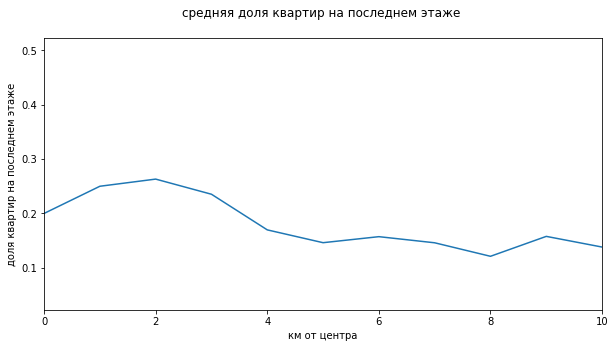

In [147]:
# строю график 
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.query('locality_name=="Санкт-Петербург"').groupby('city_centers_km')['last_floor'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 10)
plt.xlabel('км от центра')
plt.ylabel('доля квартир на последнем этаже')
plt.title('средняя доля квартир на последнем этаже \n')
plt.show()

Средняя доля квартир на последнем этаже немного уменьшается, начиная со 2го км и вряд ли объясняет провал в ценах на 3м километре. 

Посмотрим на средние площади квартир

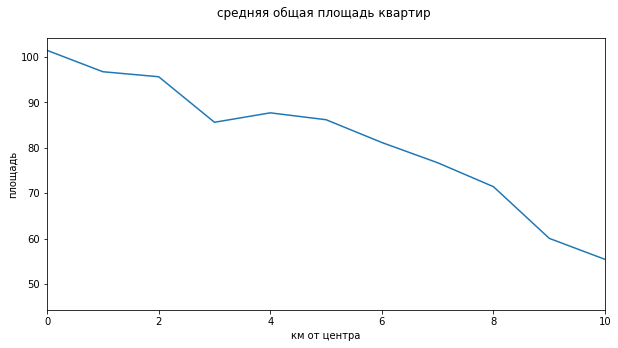

In [148]:
# строю график 
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.query('locality_name=="Санкт-Петербург"').groupby('city_centers_km')['total_area'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 10)
plt.xlabel('км от центра')
plt.ylabel('площадь')
plt.title('средняя общая площадь квартир \n')
plt.show()

Действительно на 3м километре квартиры относительно маленькие, и площадь снова увеличивается в квартирах, расположенных в 4 км от центра.

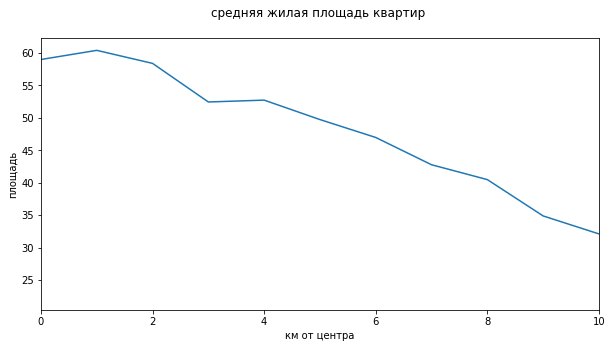

In [149]:
# строю график 
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.plot(data.query('locality_name=="Санкт-Петербург"').groupby('city_centers_km')['living_area'].mean().values.astype(float))
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 10)
plt.xlabel('км от центра')
plt.ylabel('площадь')
plt.title('средняя жилая площадь квартир \n')
plt.show()

Очень похожая картина наблюдается и в отношении жилой площади - в 3км от центра они ниже, чем в 4 км от центра.

Похоже, что квартиры на 3м километре от центра города чуть чаще расположены на первом этаже, имеют немного меньшую общую и жилую площадь - все эти компоненты в совокупности приводят к тому, что они оказываются дешевле, чем квартиры, находящиеся немного дальше от центра.

### Общий вывод

В данном проекте я изучила данные с Яндекс.Недвижимость.

Вначале данные надо было обработать из-за некоторых ошибок в названиях, типах и большого числа пропусков. Многие пропуски были связаны с тем, что в объявлении не были указаны какие-то данные, большинство пропусков в геоданных скорее всего были связаны с ошибкой выгрузки. Некоторые пропуски я заполнила вручную на логичные значения (balcony), для некоторых использовала медиану по локации (пруды и парки поблизости), для колличественных данных о квартирах я использовала метод knn везде кроме переменной days_exposition, потому что пропуски в ней информативны и говорят, что квартира пока не продана. После заполнения пропусков распределения данных выглядели так же как я и предполагала (близко к Пуассону), поэтому я прихожу к выводу, что пропуски были заполнены правильно.

После заполнения пропусков я рассмотрела подозрительные значения. Некоторые наблюдения с выбросами я удалила, некоторые были свидетельством ошибки заполнения (высота полотков) и их было легко исправить. 

Исследование распределений переменных уже позволило сделать некоторые интересные выводы: например, видно снижение активности в объявлениях на праздниках и в выходные дни.

Я провела регрессионный анализ того, что влияет на цену. Оказывается, что увеличение площади квартиры (и отдельно жилой и отдельно кухни) значимо увеличивает стоимость квартиры. Неожиданно, больше комнат при прочих равных значимо уменьшает стоимость квартиры. Квартиры на первом и на последнем этажах значимо дешевле, чем квартиры на промежуточных этажах. Неожиданным был вывод, что цены на аналогичные квартиры росли с течением времени. Отрицательный корреляция между годом и ценой связана не с падением цен, а с характеристиками проданных квартир в разные годы: раньше продавались большие дорогие квартиры, в более поздние года, относительно меньшие и более дешевые. 

Наибольшее число объялений приходилось на Санкт-Петербург, что логично, поскольку там просто больше предложение жилья. Среди 10 самых активных локаций на Яндекс.Маркете самые дорогие квадратные метры были в Санкт-Петербурге (в среднем около 112.5 т.р.) и самые дешевые были в Гатчине (около 68.5 т.р.).

В последней части я рассчитала среднюю стоимость каждого киломентра в Санкт-Петербурге. Как и ожидалось, чем дальше квартиры от центра, тем в среднем меньше они стоят. При этом есть участок немонотонности на 3м км (где квартиры чуть чаще на первом этаже и немного меньше по площади, чем квартиры на соседним километрах) и на 27м километре (где продавалось несколько очень дорогих квартир). В целом, имеет смысл ограничить километраж Санкт-Перербурга радиусом в  20 километров от центра, потому что на более удалённых километрах объявления скорее всего принадлежат другим населённым пунктам, которые тем не менее административно считаются Санкт-Петербургом.